# Predicción del Nivel de Pobreza de Hogares en Costa Rica

El objetivo de la competencia para la Predicción del Nivel de Pobreza de Hogares en Costa Rica es desarrollar modelos de machine learning que puedan predecir el nivel de pobreza de hogares usando características a nivel individual y a nivel de hogares. Este proyecto de ciencia datos para el bien social, ofrece la oportunidad de utilizar tus habilidades para beneficiar a la sociedad y no solo para lograr que las personas hagan click en publicidad.

En este notebook, iremos paso a paso para implementar una solución basada en machine learning: primero, los introduciremos al problema, luego realizaremos un Análisis de Datos Exploratorio con los datos, trabajaremos en ingenería de características, pondremos a prueba diferentes modelos de machine learning y seleccionaremos un modelo. __El fin de este notebook es servir como herramienta educativa que entrega las bases necesarias para poder implementar otros proyectos de machine learning. 

Este notebook corresponde a una competencia Kaggle. Si quieres saber más puedes revisar el [proyecto Kaggle](https://www.kaggle.com/c/costa-rican-household-poverty-prediction).


## El Problema a resolver y estructura de los datos

Los datos se componen de dos datasets: `train.csv` y `test.csv`. El dataset de entrenamiento contiene 9557 filas y 143 columnas, mientras que el dataset de testeo tiene 23856 filas y 142 columnas. Cada fila representa __un individuo__ y cada columna es una __característica, ya sea individual o del hogar al que pertenece el individuo__. El dataset de entrenamiento tiene una columna adicional, `Target`, que representa el nivel de pobreza en una escala del 1 al 4 y es el título de la competencia. El valor 1 corresponde al caso más extremo de pobreza.

Este es un __problema de machine learning supervisado de clasificación multi-clase__:

* __Supervisado__: se entregan las etiquetas al dataset de entrenamiento
* __Clasificación Multi-clase__: las etiquetas son valores discretos con 4 clases

### Objetivo


El objetivo es predecir el nivel de pobreza a __nivel de hogares__. Se entrega información a nivel individual con cada individuo teniendo características especificas pero también información sobre el hogar al que pertenece. En orden de crear un dataset para la tarea, hemos _agregado los datos individuales_ para cada hogar. No obstante, hemos de hacer una predición a nivel individual en el dataset de testeo, pero _"Solo los que encabezan cada hogar serán utilizados en la asignación de puntaje"_, lo cual quiere decir que queremos predecir pobreza a nivel de hogares.

__Nota important: mientras todos los miembros del hogar debiesen tener el mismo ID en el dataset de entrenamiento, hay errores donde individuos que viven en un mismo hogar tienen diferentes ID. En esos casos, debemos usar la etiqueta asignada al que encabeza cada hogar, que puede ser identificado en las filas que contienen `parentesco1 == 1.0`.__ 

Los valores de la variable `Target` representan el nivel de pobreza de la siguiente manera:

    1 = pobreza extrema
    2 = pobreza moderada 
    3 = hogares vulnerables 
    4 = hogares no vulnerables

Las explicaciones para cada una de las 143 columnas puede encontrarse en la [documentación de la competencia](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data), pero algunas en particular las explicamos a continuación:

* __Id__: identificador individual, no es una característica!
* __idhogar__: identificador para cada hogar. Esta variable no es una característica, pero será usada para agrupar a los individuos por hogar ya que todos los individuos de un hogar tienen un identificador común.
* __parentesco1__: indica si la persona es quien encabeza el hogar
* __Target__: la etiqueta de interés, que debiese ser la misma para todos los individuos de un mismo hogar.

Cuando armemos un modelo, entrenaremos a nivel de hogares con la etiqueta par acada hogar _nivel de pobreza del individuo que encabeza el hogar_. Los datos crudos contienen una mezcla de características a nivel individual y de hogares y tendremos que encontrar la forma de agrupar los datos individuales por hogar. Algunos individuos pertenecen a hogares sin un individuo que encabece dicho hogar, lo cual quiere decir, lamentablemente, que no podremos utilizar esos casos para el entrenamiento. Estos detalles se encuentran es los datos del __mundo real__ todo el tiempo, y por ende es un buen entrenamiento para proyectos futuros.

### Métrica

Buscamos construir modelos de machine learning que prediga el número que indica el nivel de pobreza de un hogar. Nuestras predicciones se harán utilizando el __Puntaje Macro F1__, ya que permite trabajar con problemas multi-clase _sin tomar en cuenta etiquetas que pudiesen estar desbalanceadas_. En otras palabras, cuántas veces ocurre cada etiqueta (1, 2, 3, o 4) no se toma en cuenta en el calculo. En este problema, las etiquetas no están balanceadas, por lo que es extraña la decisión de usar dicha métrica. Sin embargo, fue la decisión de los organizadores.


## Mapa de ruta

El objetivo final es un modelo de machine learning que pueda predecir el nivel de pobreza de hogares. Sin embargo, antes de empezar a modelar, es importante entender el problema y los datos. Además, queremos evaluar varios modelos antes de elegir "el mejor" y luego de construir el modelos queremos investigar las predicciones.
El mapa de ruta es el siguiente:

1. Entender el problema
2. Análisis de Datos Exploratorio
3. Ingeniería de características para tener un dataset limpio y con la estructura correcta para trabajar
4. Comparar varios modelos de machine learning básicos
5. Intentar modelos de machine learning más complejos
6. Optimizar el modelo de machine learning seleccionado
7. Investigar las predicciones logradas en base al problema
6. Conclusiones y próximos pasos 

Para efectos de este workshop solo llegaremos al punto 5.

Los pasos mencionados son iterativos, lo cual quiere decir que mientras iremos paso a paso, podemos devolvernos a pasos previos para reevaluar decisiones. En general la ciencia de datos es no-linear en su práctica, y siempre evaluamos constantemente nuestras decisiones pasadas e implementamos mejoras. 

# Vamos a empezar

Ahora que ya entendemos el problema, pasaremos al Análisis de Datos Exploratorio e ingeniería de características. Para el Análisis de Datos Exploratorio, examinaremos anomalías, tendencias, correlaciones, o patrones que puedan ser utilizado para hacer ingeniería de características y para crear los modelos. Nos aseguraremos de investigar nuestra data de forma cuantitativa (mediante estadísticos) y de forma visual (con plots y figuras). 

Una vez tengamos noción de nuestros datos y correlaciones potencialmente útiles, podemos hacer algo de ingeniería de características (la parte más importante en la ruta del machine leatning) y establecer un modelo base. 

#### Importar los datos

Utilizaremos paquetes muy típicos en ciencias de datos: `Pandas`, `numpy`, `matplotlib`, `seaborn`, y eventualmente `sklearn` para modelar. 

In [60]:
# Manipulación de los datos
import pandas as pd
import numpy as np

# Visualización 
import matplotlib.pyplot as plt
import seaborn as sns

# Definimos algunos parámetros para el formato de los gráficos
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

In [61]:
#!pip install pandas numpy matplotlib seaborn 

### Leer los datos y obtener un resumen

In [62]:
pd.options.display.max_columns = 150

# Importar los datos
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


Nos permite tener una vista de las columnas, que al parecer no están en ningún orden específico. Para tener una mirada rápida de los datos usamos `df.info()`.

In [63]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


Esto nos dice que hay 130 columnas de tipo integer, 8 de tipo float (numéricas), y 5 de tipo objeto. Las columnas integer probablemente serán variables Booleanas (de valor 0 o 1) o variables ordinales con valores discretos. Las columnas tipo objeto probablemente sean un problema, ya que no pueden ser directamente ingresadas a un modelo de machine learning.

Echemos un vistazo a los datos de testeo que tiene más filas que la de entrenamientos. Sí tiene una columna menos porque no está la variable target!

In [64]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


#### Columnas Integer

Miremos la distribución de de valores únicos en las columnas tipo integer. Para cada columnas, contaremos el número de valores únicos que contiene y lo visualizaremos un gráfico de barras.

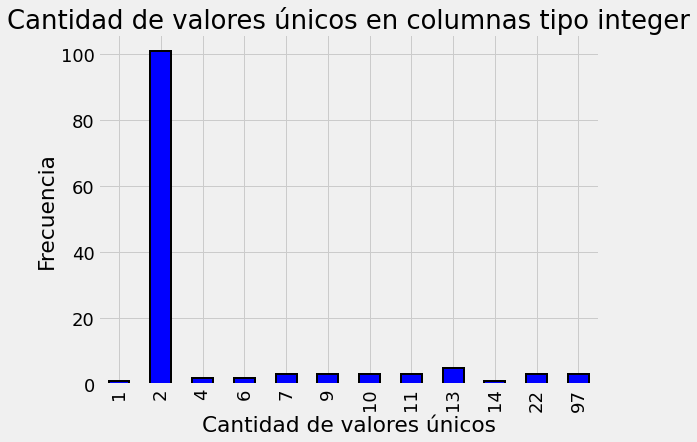

In [65]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color = 'blue', 
                                                                             figsize = (8, 6),
                                                                            edgecolor = 'k', linewidth = 2);
plt.xlabel('Cantidad de valores únicos'); plt.ylabel('Frecuencia');
plt.title('Cantidad de valores únicos en columnas tipo integer');

Las columnas con solo 2 valores son Booleanas (0 o 1). En varios casos, los booleanos ya están a nivel de hogar. Por ejemplo `refrig` indica su la casa tiene o no un refrigerados. Cuando debamos crear características a partir de columnas Booleanas que están a nivel de hogar, no necesitaremos agrupar la información. Sin embargo, las columnas de tipo Booleanas que están a un nivel individual tendremos que agruparlas.

#### Columnas Float

En los gráficos de a continuación mostramos la distribución de cada variable tipo float. Usaremos [`OrderedDict`](https://pymotw.com/2/collections/ordereddict.html) para identificar con colores los niveles de pobreza. Así podemos ver si hay diferencias significativas en la distribución de cada variable dependiendo del nivel de pobreza.

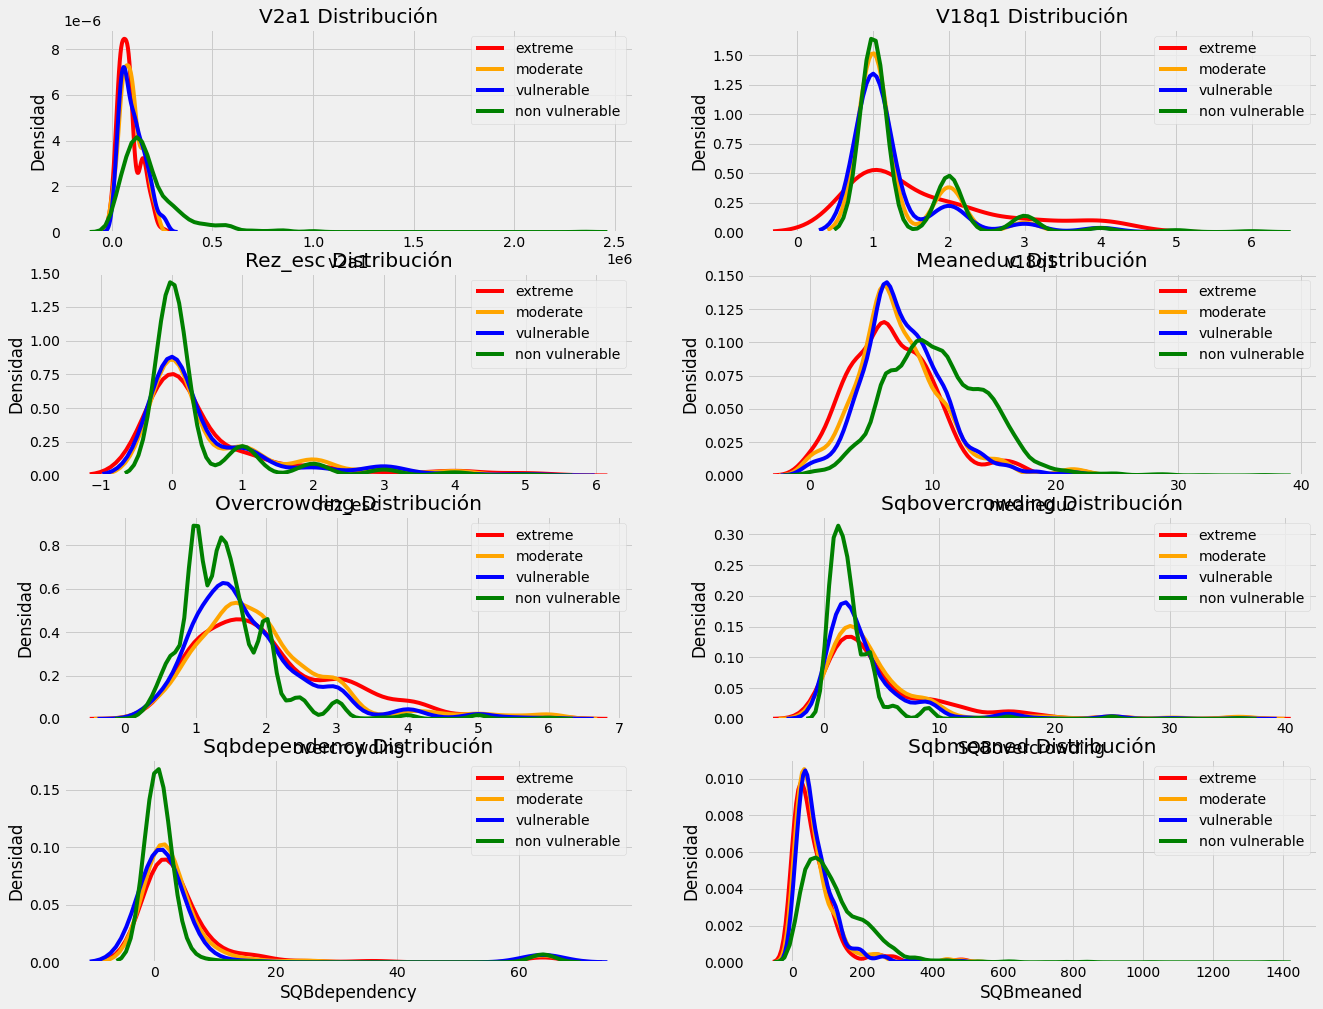

In [66]:

from collections import OrderedDict

plt.figure(figsize = (20, 16))
plt.style.use('fivethirtyeight')

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

# Iterate through the float columns
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
        plt.title(f'{col.capitalize()} Distribución'); plt.xlabel(f'{col}'); plt.ylabel('Densidad')

#plt.subplots_adjust(top = 2)

Luego calcularemos correlaciones entre las variables y la variable `Target` para observar las relaciones entre características, pero estos plots ya pueden darnos una idea de qué variables podrían ser "más relevantes" para introducir a un modelo. Por ejemplo, `meaneduc`, que representa el nivel de educación promedio de los adultos del hogar, aparece como asociado al nivel de pobreza.

#### Columnas Objeto

Las columnas tipo objeto las podemos observar de la siguiente manera:

In [67]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


`Id` y `idhogar` son tipo objeto porque son variables de identificación. Sin embargo, las otras columnas parecen ser una mezcla de caracteres y números, de lo cual tendremos que ocuparnos antes de pasar al modelamiento. Acorde a la documentación para dichas columnas:

* `dependency`: nivel de dependencia, calculado = (número de miembros del hogar menores de 19 o mayores de 64) / (número de miembros del hogar entre 19 y 64 años)
* `edjefe`: años de educación del hombre que encabeza el hogar, basado en la interacción entre años de educación, encabezar el hogar, y género, sí=1 y no=0
* `edjefa`: años de educación de la mujer que encabeza el hogar, basado en la interacción entre años de educación, encabezar el hogar, y género, sí=1 y no=0

Estas explicaciones aclaran el panorama. Para estas tres variables __"sí" = 1__ y __"no" = 0__. Podemos corregir estas variables usando un mapeo y convirtiendo a float.

In [68]:
mapping = {"yes": 1, "no": 0}

# Hacemos la misma operación para datos de entrenamiento y de testeo
for df in [train, test]:
    # Rellenamos los valores con el mapeo correcto
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


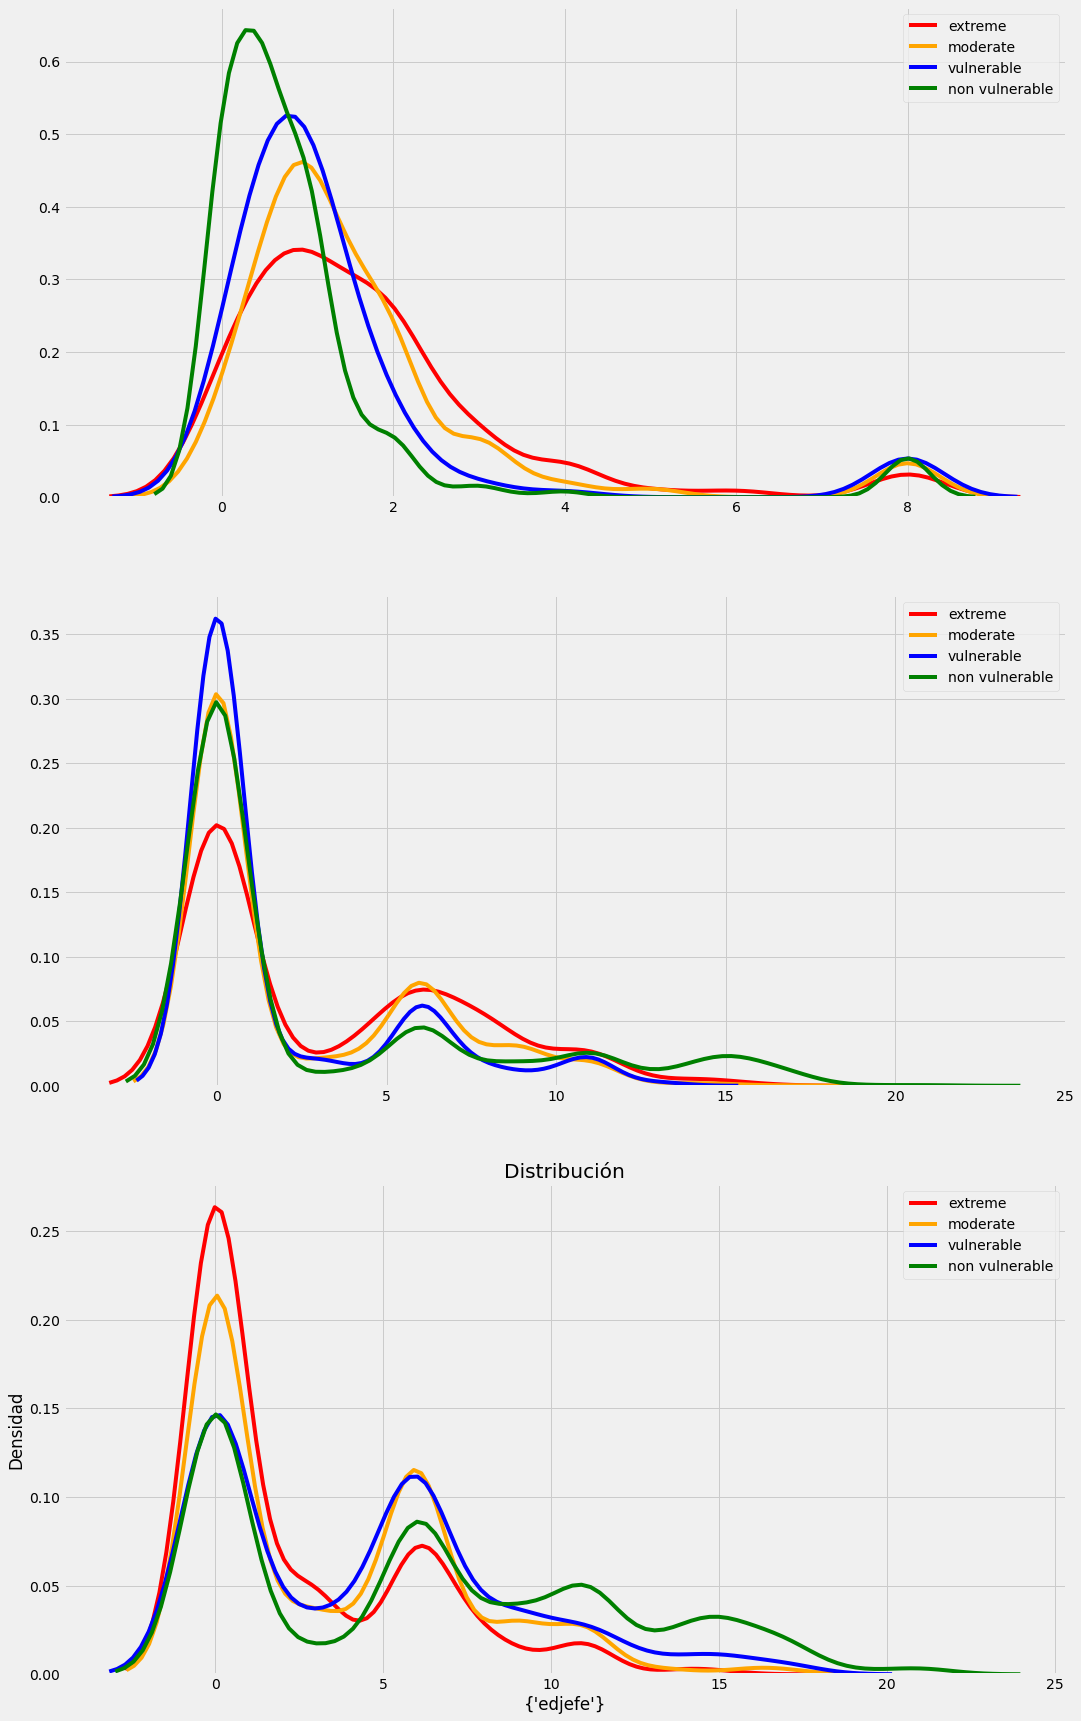

In [69]:
plt.figure(figsize = (16, 12))

# Iteramos en columnas float
for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
    ax = plt.subplot(3, 1, i + 1)
    # Iteramos por nivel de pobreza
    for poverty_level, color in colors.items():
        # Ploteamos cadad nivel como una linea separada
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
 #  plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')
plt.title('Distribución'); plt.xlabel({col}); plt.ylabel('Densidad')

plt.subplots_adjust(top = 2)

Ahora estas variables están correctamente representadas como números y pueden ser ingresadas a un modelo de machine learning.
Para hacer operaciones aritméticas como la de arriba de forma un poco más simple, uniremos los datasets de entrenamiento y teste. Esto es importante ya que la ingeniería de características debe ser aplicada por igual a todos los datos para tener exactamente las mismas características. Luego podremos dividir los datasets basados en la variable `Target`.


In [70]:
# Agregamos valores nulos a la variable que vamos a testear
test['Target'] = np.nan
data = train.append(test, ignore_index = True)

## Explorando la Distribución de Etiquetas

A continuación podemos tener una idea de qué tan desbalanceado está el problema, mirando la distribución de las etiquetas de nuestra variable objetivo `Target`. Hay cuatro posibles niveles, indicando 4 niveles diferentes de pobreza. Para mirar las etiquetas correctamente deberemos seleccionar solo el subset de datos donde `parentesco1 == 1` ya que esos son los individuos que encabezan cada hogar. 

El gráfico de barras muestra la distribución de las etiquietas de entrenamiento (ya que no hay etiquetas para esta variable en la base de datos de testeo).

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

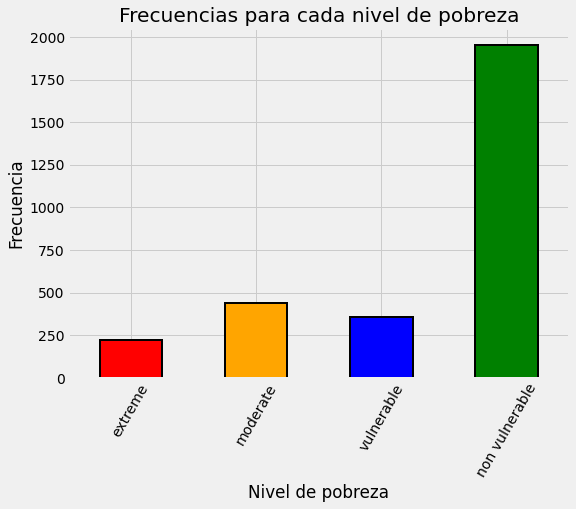

In [71]:
# Individuos que encabezan un hogar
heads = data.loc[data['parentesco1'] == 1].copy()

# Etiquetas para el entrenamiento
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target', 'idhogar']]

# Frecuencia en la que la muestra tiene cada valor posible de la variable target
label_counts = train_labels['Target'].value_counts().sort_index()

# Gráfico de barra con la ocurrencia de cada valor posible de la variable target
label_counts.plot.bar(figsize = (8, 6), 
                      color = colors.values(),
                      edgecolor = 'k', linewidth = 2)

# Formatear gráfico
plt.xlabel('Nivel de pobreza'); plt.ylabel('Frecuencia'); 
plt.xticks([x - 1 for x in poverty_mapping.keys()], 
           list(poverty_mapping.values()), rotation = 60)
plt.title('Frecuencias para cada nivel de pobreza');

label_counts

Como podemos obervar, hay muchos más hogares que clasifican como _no vulnerables_ que hogares que clasifican en las otras categorías. Esto significa que nuestras variables están desbalanceadas. 

Un problema con clasificaciones desbalanceadas es que el modelo de machine learning puede tener dificultades para predecir las categorías que tienen menos datos.

## Haciendose cargo de etiquetas incorrectas

Como con cualquier dataset del mundo real, el de Pobreza en Costa Rica tiene algunos problemas. Normalmente la mayoría del tiempo se pasa en limpiar los datos corrigiendo anomalías y errores. En este caso un problema importante, pues sabemos que hay errores en la forma en que se clasificó a algunos individuos respecto a la variable objetivo, porque _individuos del mismo hogar tienen diferentes niveles de pobreza_. No sabemos por qué, pero sí se nos ha dicho que debemos quedarnos con la información del que encabeza hogar. 

### Identificar Errores

Primero debemos encontrar los errores para corregirlos. Para encontrar los hogares con clasificaciones de pobreza diferentes para cada familiar que compone dicho gogar, podemos agrupar los datos por hogar y luego revisar si hay un solo valor en la variable `Target`.

In [72]:
# Agrupar por hogar y descubrir la cantidad de valores únicos que adoptan
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Hogares donde la variable target no es la misma para todos los individuos
not_equal = all_equal[all_equal != True]
print('Hay {} hogares donde los miembros de la familia no tienen el mismo nivel de pobreza'.format(len(not_equal)))

Hay 85 hogares donde los miembros de la familia no tienen el mismo nivel de pobreza


Miremos un ejemplo

In [73]:
train[train['idhogar'] == not_equal.index[0]][['idhogar', 'parentesco1', 'Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


Los organizadores del estudio dicen que la etiqueta correcta será la de la persona que encabeza el hogar, donde `parentesco1 == 1`. Para este hogar, la etiqueta correcta es __3__ para todos los miembros que lo componen. Esto lo corregiremos a continuación reasignando el nivel de pobreza de cada familiar.

### Familias sin un individuo que encabeza el hogar

Podemos corregir todas las discrepancias en la variable objetivo dentro de cada hogar asignando a partir del identificado de hogares. Pero aún falta investigar cómo corregir el problema de los hogares sin individuos que los encabecen. A continuación indagaremos este tema

In [74]:
households_leader = train.groupby('idhogar')['parentesco1'].sum()

# Encontremos aquellos hogares que carecen de un individuo que los encabece
households_no_head = train.loc[train['idhogar'].isin(households_leader[households_leader == 0].index), :]

print('Hay {} hogares sin nadie que los encabece.'.format(households_no_head['idhogar'].nunique()))

Hay 15 hogares sin nadie que los encabece.


In [75]:
# Encontremos aquellos hogares sin nadie que los encabece y que además sus integrantes tengan niveles de pobreza diferentes
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
print('{} Hogares no tienen nadie que los encabece y además tienen niveles de pobreza diferentes'.format(sum(households_no_head_equal == False)))

0 Hogares no tienen nadie que los encabece y además tienen niveles de pobreza diferentes


No hay hogares sin individuos que lo encabecen y que además sus miembros tengan etiquetas diferentes en la variable de interés. Eso sí, hay 15 hogares que carecen de un individuo que los encabecen. Ya que la instrucción fue quedarse solo con la etiqueta de la variable de interés del individuo que encabeza el hogar, deberemos dejar fuera todos aquellos hogares sin individuos que lo encabecen.

### Corregir Errores

Ahora corregiremos los casos en que los hogares tienen un individuo que los encabeza __y__ en que los miembros del hogar tienen diferentes etiquetas en la variable objetivo.

In [76]:
# Iteramos po hogar
for household in not_equal.index:
    # Encontramos el nivel de pobreza único para cada hogar
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    
    # Reemplazamos valores para que todos los individuos de cada hogar tengan el mismo nivel de pobreza
    train.loc[train['idhogar'] == household, 'Target'] = true_target
    
    
# Agrupamos por hogar y observamos los valores únicos de la variable target
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Hogares dentro de los cuales hay diferentes niveles de pobreza
not_equal = all_equal[all_equal != True]
print('Hay {} hogares donde los miembros de la familia no tienen el mismo nivel de pobreza'.format(len(not_equal)))

Hay 0 hogares donde los miembros de la familia no tienen el mismo nivel de pobreza


## Datos Perdidos

Uno de los pasos más importantes de un análisis exploratorio es encontrar los valores perdidos y determinar cómo se manejarán. Los valores perdidos deben ser rellenados para usar un modelo de machine learning y debemos pensar la mejor estrategia para hacerlo, lo cual implica analizar los datos perdidos por variable.

Primero miraremos el porcentaje de datos perdidos por columna.

In [77]:
# Número de perdidos por columna
missing = pd.DataFrame(data.isnull().sum()).rename(columns = {0: 'total'})

# Creamos porocentaje de datos perdidos por columna
missing['porcentaje'] = missing['total'] / len(data)

missing.sort_values('porcentaje', ascending = False).head(10).drop('Target')

,total,porcentaje
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


No tenemos que preocuparnos de la variable objetivo o de interés (`Target`) porque definimos solo datos perdidos en esa variable en el dataset de teste. Sin embargo, necesitamos ocuparnos de las otras 3 columnas que muestran altos porcentajes de datos perdidos.

__v18q1__: Número de tablets

Empecemos por `v18q1` que indica el número de tablets en el hogar. Como se trata de una variable a nivel de hogar, solo miraremos esa variable en los individuos qeu encabezan un hogar.

#### Conteos por valor que adopta la variable


In [78]:
def plot_value_counts(df, col, heads_only = False):
    """Plot value counts of a column, optionally with only the heads of a household"""
    # Select heads of household
    if heads_only:
        df = df.loc[df['parentesco1'] == 1].copy()
        
    plt.figure(figsize = (8, 6))
    df[col].value_counts().sort_index().plot.bar(color = 'blue',
                                                 edgecolor = 'k',
                                                 linewidth = 2)
    #plt.xlabel(f'{col}'); plt.title(f'{col} Value Counts'); plt.ylabel('Count')
    plt.xlabel({col}); plt.title('Frecuencia de valores de la variable'); plt.ylabel('Frecuencia')
    plt.show();

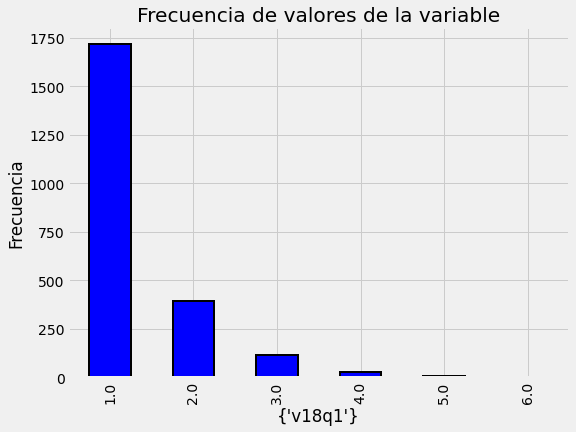

In [79]:
plot_value_counts(heads, 'v18q1')

Parece que el mayoría de los hogares cuentan con solo 1 tablet. Pero, debemos pensar en los datos que no están. En este caso, podría ser que las familias con `nan` en esta categoría simplemente cuentan con 0 tablets en el hogar. Si miramos las definiciones de variables, existe una variable `v18q` que indica si la casa tiene o no tablets. Entonces, debiéramos ver si la información de esa variable nos puede decir algo sobre nuestra hipótesis.

Si agrupamos por la variable  `v18q` (1 = tienen tablets, 0 = no tienen tablets) y calculamos el número de valores nulos en `v18q1`, podremos saber si los valores niños representan el hecho de que la familia no tenga tablets.

In [80]:
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

Bueno, parece resuelto. Cada familia con `nan` en `v18q1` no tiene una tablet. Entonces, podemos rellenar esas casillas con "0".

In [81]:
data['v18q1'] = data['v18q1'].fillna(0)

__v2a1__: Pago mensual de renta

La próxima variable con alto porcentaje de perdidos es `v2a1` que representa el pago de renta mensual.

Adempas, para observar los valores perdidos del pago mensual de renta, es interesante mirar la distribución de la variable `tipovivi_`, las columnas muestran el estatus de compra/arriendo de cada hogar. Para este plot, mostramos el estado de compra/arriendo del hogar de aquellas casas que tienen `nan` en el pago mensual de renta.

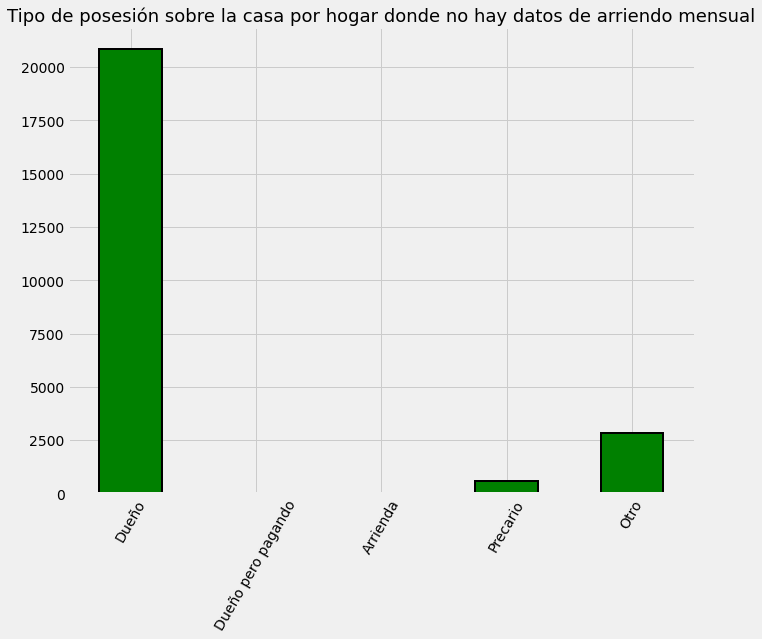

In [82]:
# Variables indicando que la persona es dueña de la casa
own_variables = [x for x in data if x.startswith('tipo')]


# Gráfico de las variables del tipo de posesión sobre la casa de aquellos con datos perdidos
# en la variable de pago de renta mensual
data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize = (10, 8),
                                                                        color = 'green',
                                                              edgecolor = 'k', linewidth = 2);
plt.xticks([0, 1, 2, 3, 4],
           ['Dueño', 'Dueño pero pagando', 'Arrienda', 'Precario', 'Otro'],
          rotation = 60)
plt.title('Tipo de posesión sobre la casa por hogar donde no hay datos de arriendo mensual', size = 18);

El significado de de las categorías de la variable `tipovivi_` son las siguientes:

    tipovivi1, =1 dueño de la casa (comprada)
    tipovivi2, =1 dueño de la casa, en proceso de compra
    tipovivi3, =1 arrienda la casa
    tipovivi4, =1 precario
    tipovivi5, =1 otro(assignada, prestada)

Asunto resuelto! Bueno, casi: las casas que no pagan una renta mensual, en general, son dueños de la casa. En otros casos, no estaremos seguros de la razón de los datos perdidos. 

Para aquellos casos donde las casas han sido compradas y tienen datos perdidos en la variable de pago de renta mensual, fijaremos un valor de 0 en la variable de pago de renta mensual. Para el resto, no haremos nada por ahora, mas que agregar un indicador de cada valor perdido.

In [83]:
# Para los dueños de su hogar, rellenamos sus valores perdidos con 0
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# creamos columna de perdidos en renta mensual
data['v2a1-missing'] = data['v2a1'].isnull()

data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

__rez_esc__: años de atraso en el colegio


En esta columna es posible que los datos perdidos se deban a que no hay ningún integrante del hogar que vaya al colegio. Testeemos esto a partir de revisar las edades de aquellos individuos que tienen valores perdidos en esta columna y de los que no.

In [84]:
data.loc[data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

Esto nos indica que la persona con más edad con dato perdido en esta variable tiene 17 años. Para cualquier persona de esta edad, tal vez podamos asumir que simplemente no van al colegio. Miremos las edades de aquellos que sí tienen valores perdidos.

In [85]:
data.loc[data['rez_esc'].isnull()]['age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

Luego de investigar sobre el significado de esta variable en las [discusiones de la competencia](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/discussion/61403), descubrimos que esta variable solo es válida para personas entre 7 y 19 años, el resto de los individuos debe tener un 0 en esta variable. Así, podemos setear a 0 en esta variable a todos los individuos menores de 7 y mayores de 19 años. Para el resto, dejamos los valores como están, pero indicando que son valores perdidos.

In [86]:
# Si la persona es menor a 7 y mayor a 19 y tiene datos perdidos en la variable atrasao en el colegio, setear a 0 
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

# Agregamos una marca para aquellos entre 7 y 19 años con datos perdidos en la variable atraso en el colegio
data['rez_esc-missing'] = data['rez_esc'].isnull()

Además, hay un outlier en la variable `rez_esc`. De nuevo, sabemos que el valor máximo que puede adoptar esta variable es de 5, por lo que definiremos que cualquier valor que sea mayor a 5, se fije en 5.

In [87]:
data.loc[data['rez_esc'] > 5, 'rez_esc'] = 5

## Graficar dos variables categóricas

Para mostrar cómo dos variables categóricas interactúan entre sí, hay varias opciones de gráficos: scatterplots, gráficos de barra, boxplots, etc. No estaba satisfecho con ninguna de estas opciones, así es que creé mi función propia, que esencialmente un scatterplot de dos variables categóricas donde el tamaño de los puntos indica el porcentaje de un valor y representado para cada valor x.

In [88]:
def plot_categoricals(x, y, data, annotate = True):
    """Plot counts of two categoricals.
    Size is raw count for each grouping.
    Percentages are for a given value of y."""
    
    # Conteo bruto 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # Calcular frecuencias por grupo de x y de y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Renombrar columnas y resetear el índice
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Agregamos el conteo bruto
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    # Scatter plot por porcentaje
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightgreen',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # Anotar plot con texto
        for i, row in counts.iterrows():
            # Ajustar texto a los parámetros adecuados
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), 
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy')
                      #   s = f"{round(row['percent'], 1)}%")
        
    # Agregamos marcas
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transformamos min y max para distribuir uniformemente el dominio cuadrado
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # Tamaño 5 para la leyenda
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # Marcadores para la leyenda
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'lightgreen',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # Leyenda y formateo
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # Ajustar limites de los ejes
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}"); plt.ylabel(f"{y}"); plt.title(f"{y} vs {x}");

TypeError: annotate() missing 1 required positional argument: 's'

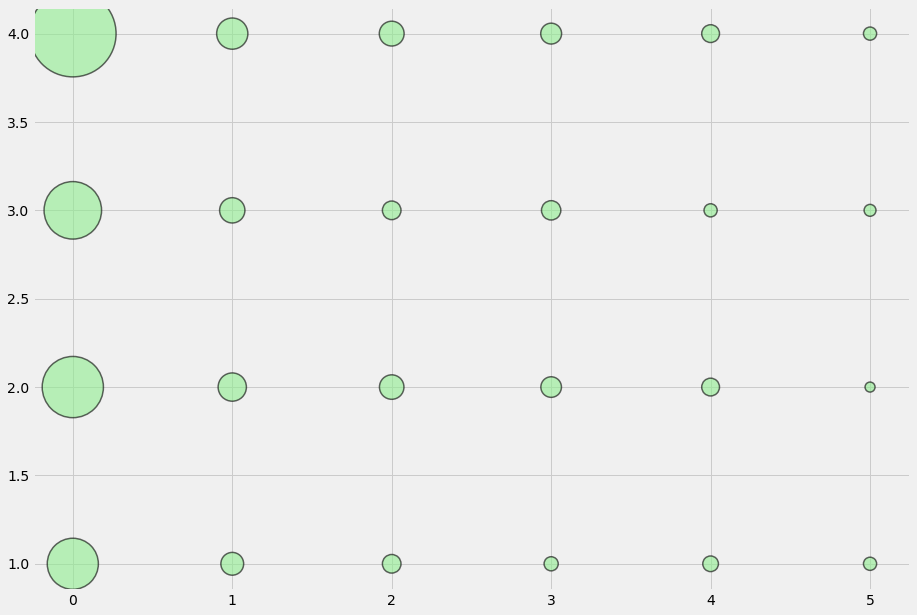

In [89]:
plot_categoricals('rez_esc', 'Target', data);

El tamaño de los puntos representa el conteo bruto. Para interpretar el plot, elige un valor de y, y luego lee siguiendo la fila. Por ejemplo, para un nivel de pobreza de 1, el 93% de los individuos no está atrasado en el colegio, con un total de 800 individuos. Y, app un 0.4% de los individuos están 5 años atrasados en el colegio de un total de 50. Este plot intenta mostrar tanto el conteo total y la proporción por categoría: no es perfecto, pero le quise dar una oportunidad.

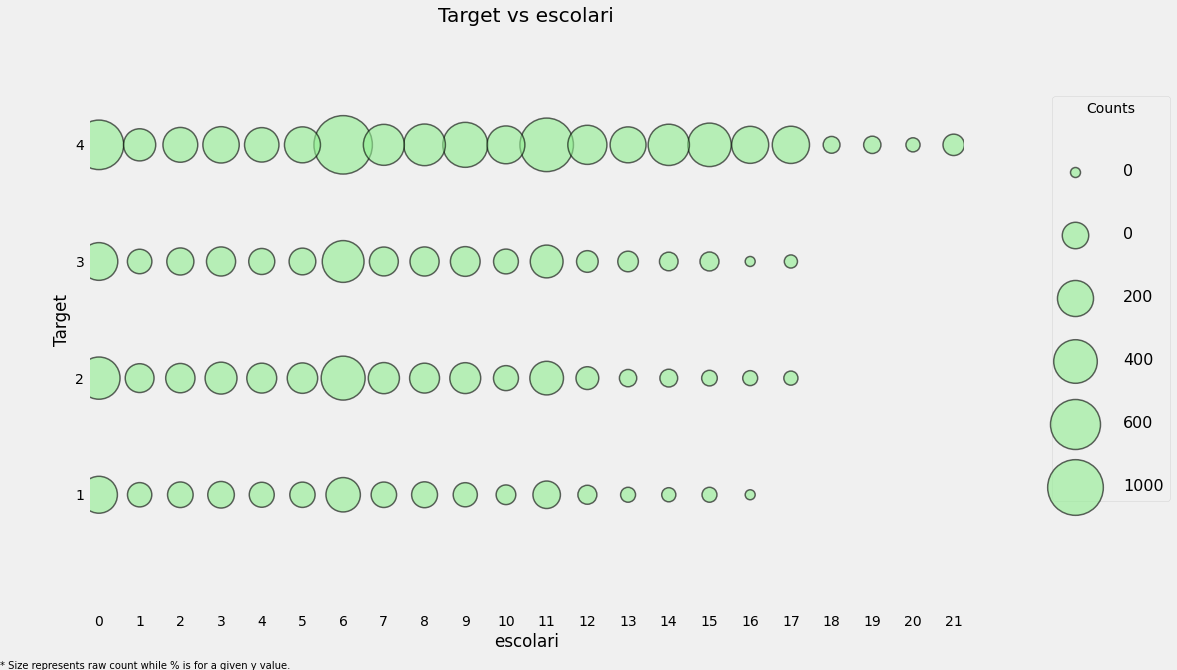

In [90]:
plot_categoricals('escolari', 'Target', data, annotate = False)

Los valores perdidos que quedan ahora en cada columna serán rellenados, en un proceso conocido como `Imputación`. Hay varios tipos de imputación usados comunmente y uno de los más simples y efectivos es rellenar los valores perdidos con la `mediana` de la columna.

Como paso final en la corrección de datos perdidos, podemos plotear la distribución de la variable objetivo para el caso donde hay datos perdidos.

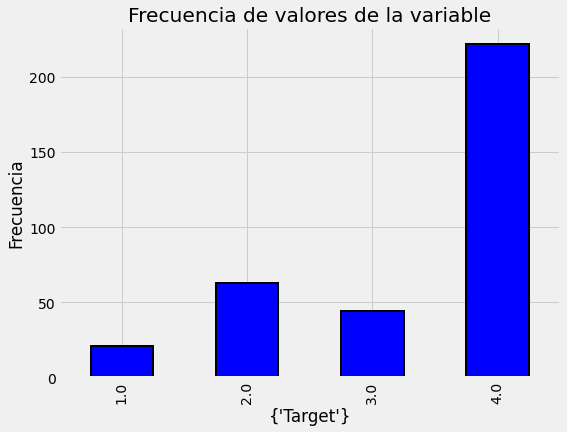

In [91]:
plot_value_counts(data[(data['rez_esc-missing'] == 1)], 
                  'Target')

La distribución aquí parece ser igual que en el caso en que tenemos todos los datos.

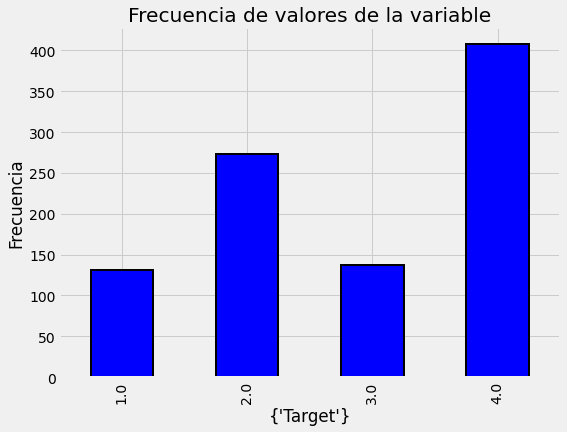

In [92]:
plot_value_counts(data[(data['v2a1-missing'] == 1)], 
                  'Target')

Aquí observamos una mayor prevalencia del nivel 2 "pobreza moderada", se ve como si pudiese ser un indicador de pobreza entonces.
__Esto es importante__: a veces los datos perdidos son tan importantes como los datos presentes.

# Ingeniería de características

Hay bastante más que podemos hacer para explorar los datos, pero primero deberíamos trabajar en consolidar las variables y los datos para que estén agrupados por hogar. Ya tenemos parte de la información para cada hogar, pero para el entrenamiento, necesitamos _toda_ la infomación resumida para cada hogar. Esto significa agrupar a los individuos por hogar con `groupby` y hacer un agregado `agg` de las variables individuales.

En otro notebook, muestro cómo podemos automatizar esta parte, pero ahora lo haremos a mano.

## Definiendo las columnas

A veces en ciencia de datos tenemos que ensuciarnos las manos indagando en los datos o haciendo un trabajo tedioso que tiene un alto costo en tiempo. Pero es parte del análisis: debemos definir qué columnas están a nivel individual y a nivel de hogar usando la [descripción de los datos](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data). Simplemente no hay otra forma. Pero ya lo hice por ustedes.

Definiremos las distintas variables porque necesitamos darles un tratamiento diferencial a cada una. Una vez que hayamos definido qué variable pertenece a qué unidad de observación (hogar/individual), podemos comenzar a hacer el agregado de acuerdo a nuestras necesidades.

El proceso es el siguiente

1. Divide las variables en nivel hogar y nivel individual
2. Encuentra agregados adecuados para los datos de nivel individual
    * Variables orfinales pueden ser agregadas estadísticamente
    * Variables Booleanas también pueden ser agregadas estadísticamente, pero a través de menos estadísticos
3. Une los agregados individuales a los datos que se encuentra a nivel hogar

### Define los tipos de variables

Hay diferentes tipos de variables:

1. Variables Individuales: son características a nivel individual
    * Booleana: Sí (1) o No (0)
    * Ordinales discretas: Números con un orden
2. Variables Hogar: son características a nivel de hogares
    * Booleana: Sí (1) o No (0)
    * Ordinales discretas: Números con un orden
    * Numéricas continuas
3. Variables cuadráticas: derivadas de escalar variables al cuadrado 
4. Variables ID: Identifica la data, y no debiesen ser usados como características

Debajo definimos las variables en cada categoría manualmente. Es tedioso, pero también necesario.

In [93]:
id_ = ['Id', 'idhogar', 'Target']

In [94]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

In [95]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [96]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

Estemos seguros que usamos todas las variables y que no se nos repitió ninguna

In [97]:
x = ind_bool + ind_ordered + id_ + hh_bool + hh_ordered + hh_cont + sqr_

from collections import Counter

print('No hay variables repetidas: ', np.all(np.array(list(Counter(x).values())) == 1))
print('Incluimos todas las variables: ', len(x) == data.shape[1])

No hay variables repetidas:  True
Incluimos todas las variables:  True


#### Variables Cuadráticas

Primero, el paso más simple: eliminaremos todas las variables cuadráticas. A veces se las transforma porque pueden ayudar a que los modelos lineales aprendan relacion entre variable que no son lineales. Sin embargo, ya que probaremos modelos más complicados, estas variables son redundantes. Están altamente correlacionadas con su versión no escalada, y por ende puede dañar el modelo agregando información irrelevante y enlenteciendo el entrenamiento.

Por ejemplo, observemos la variable `SQBage` vs `age`.

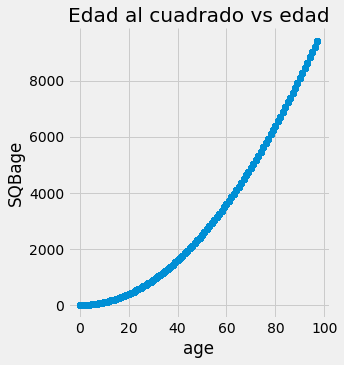

In [98]:
sns.lmplot('age', 'SQBage', data = data, fit_reg=False);
plt.title('Edad al cuadrado vs edad');

Estas variables están muy correlacionadas entre sí, y no necesitamos quedarnos con ambas.

In [99]:
# Quitar variables que son el cuadrado de otra variable (variables cuadráticas)
data = data.drop(columns = sqr_)
data.shape

(33413, 136)

## Variables ID

Estas son simples de manejar: las mantendremos tal cual están ya que las necesitamos para identificación

## Variables a nivel de hogares

Primero subseteemos para quedarnos con los individuos que encabezan un hogar y luego para quedarnos solo con las variables que describen características a nivel de hogar.

In [122]:
heads = data.loc[data['parentesco1'] == 1, :]
heads = heads[id_ + hh_bool + hh_cont + hh_ordered]
heads.shape

(10307, 99)

La mayoría de las variables a nivel de hogar pueden quedarse tal cual están: ya que queremos hacer predicciones a nivel de hogar precisamente, usamos estas variables como características predictoras. Sin embargo, también podemos eliminar algunas que sean reundantes y agregar otras derivadas de datos existentes.

### Variables redundantes a nivel de hogar

Observemos las correlaciones entre todas estas variables. Si hay algunas muy fuertemente correlacionadas, entonces tal vez querramos eliminar alguna del par.

El código a continuación identifica variables con correlaciones mayores a 0.95.

In [123]:
# Crear matrix de correlaciones
corr_matrix = heads.corr()

# Seleccionamos triángulo superior de las correlaciones
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Buscamos el índice de las columnas que presentan una correlación mayor a 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

Muestran una variable de cada pareja de variables que correlacionan con más de 0.95. Para encontrar la otra variable que compone cada pareja subsetearemos `corr_matrix`. 

In [124]:
corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9]

,r4t3,tamhog,tamviv,hhsize,hogar_total
r4t3,1.000000,0.998287,0.910457,0.998287,0.998287
tamhog,0.998287,1.000000,0.909155,1.000000,1.000000
tamviv,0.910457,0.909155,1.000000,0.909155,0.909155
hhsize,0.998287,1.000000,0.909155,1.000000,1.000000
hogar_total,0.998287,1.000000,0.909155,1.000000,1.000000


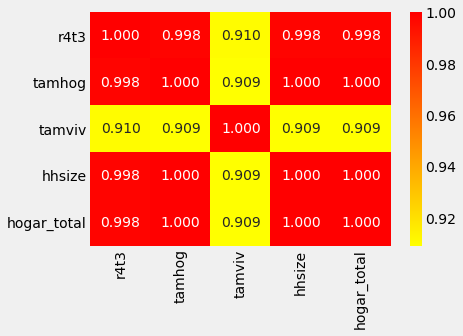

In [125]:
sns.heatmap(corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9],
            annot=True, cmap = plt.cm.autumn_r, fmt='.3f');

Hay varias variables aquí que tienen que ver con el tamaño del hogar:

* r4t3, Total de personas en el hogar
* tamhog, tamaño del hogar
* tamviv, número de personas que viven en el hogar
* hhsize, tamaño del hogar
* hogar_total, número del total de individuos que componen el hogar

`hhsize` tiene una correlación perfecta con `tamhog` y `hogar_total`. Eliminaremos ambas porque la información es redundante. También podemos eliminar `r4t3` porque tiene una correlación casi perfecta con `hhsize`.

`tamviv` no es necesariamente igual a `hhsize` porque pueden haber integrantes de la familia que no viven en el mismo hogar. Miremos estas diferencias en un scatterplot

In [126]:
heads = heads.drop(columns = ['tamhog', 'hogar_total', 'r4t3'])

/home/ale/env3/lib/python3.6/site-packages/seaborn/regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


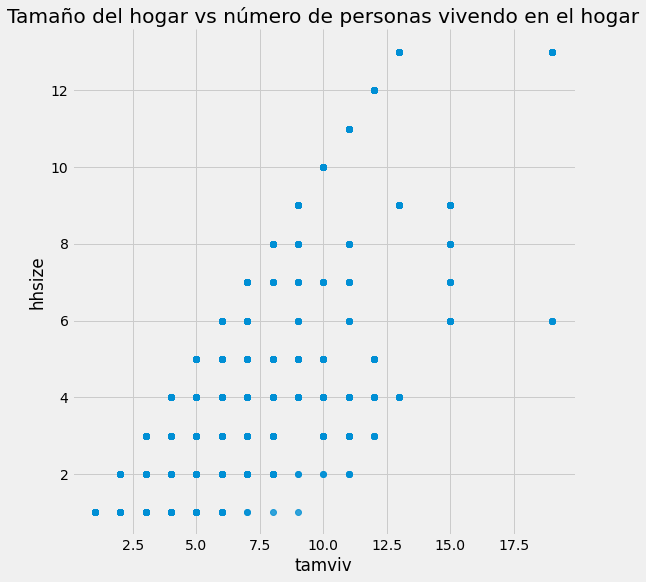

In [127]:
sns.lmplot('tamviv', 'hhsize', data, fit_reg=False, size = 8);
plt.title('Tamaño del hogar vs número de personas vivendo en el hogar');

Vemos que para algunos casos, hay más personas viviendo en el hogar que aquellas que componen la familia. Esto nos da una idea para una nueva variable: __la diferencia entre ambas medidas__

Creemos esta variable nueva

TypeError: annotate() missing 1 required positional argument: 's'

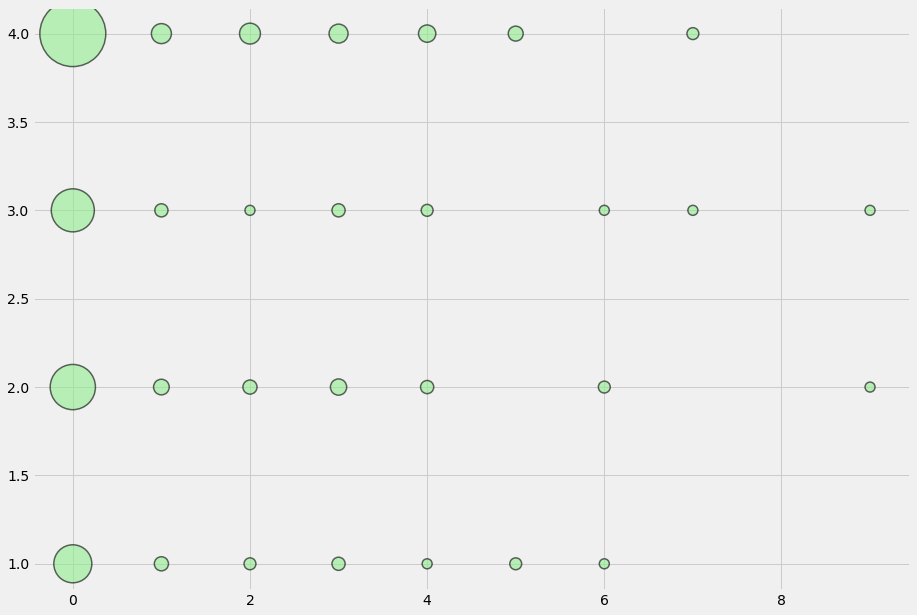

In [128]:
heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']
plot_categoricals('hhsize-diff', 'Target', heads)

Aunque la mayoría de los hogares no tienen diferencias, hay varios que tienen más personas viviendo en el hogar que miembros del hogar.

Vayamos a la próxima potencial variable redundante `coopele`

In [129]:
corr_matrix.loc[corr_matrix['coopele'].abs() > 0.9, corr_matrix['coopele'].abs() > 0.9]

,public,coopele
public,1.000000,-0.967759
coopele,-0.967759,1.000000


Estas variables indican de dónde viene la electricidad del hogar. Hay 4 opciones, y las familias que no tienen algunas de las dos opciones que aparecen en la tabla, o no tienen electricidad (`noelec`), o la obtienen de una planta privada (`planpri`).

#### Creando una variable ordinal

Comprimamos estas cuatro variables en una sola con cuatro opciones de respuesta:

    0: Sin electricidad
    1: Electricidad a partir de cooperativa
    2: Electricidad proviene de CNFL, ICA, ESPH/JASEC
    3: Electricidad proviene de planta privada

Luego de que creamos esta variable, podemos botar las cuatro anteriores. Hay varios hogares que no tienen una variable aquí, así es que les asignaremos un `nan` que luego podrá ser rellenado por imputación, y agregaremos una variable booleana que indica que no hubo medición para esta variable.

In [130]:
elec = []

# Asignar valores
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
# Crear nueva variable y otra variable que indique perdidos
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()

# Remover las variables de electricidad
# heads = heads.drop(columns = ['noelec', 'coopele', 'public', 'planpri'])

TypeError: annotate() missing 1 required positional argument: 's'

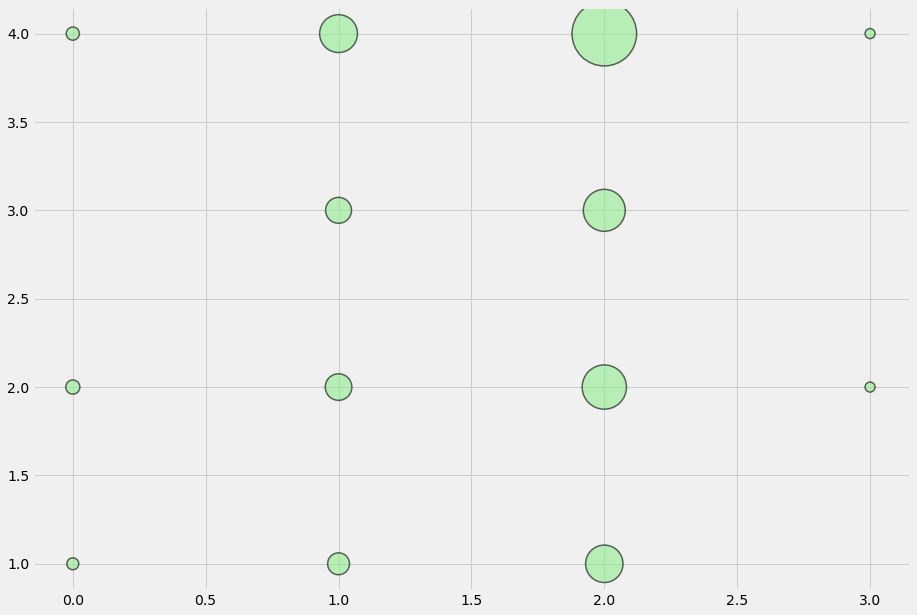

In [131]:
plot_categoricals('elec', 'Target', heads)

Podemos ver que para cada valor de Target, la mayoría de las fuentes de electricidad provienen de alguno de los proveedores que aparecen en la lista.

La última columna redundante es `area2`. Esta variable alude a si el hogar se encuentra o no en una zona rural. Pero es redundante, porque tenemos otra variable indicando si el hogar se encuentra en una zona urbana, así es que botaremos esta variable.

In [132]:
heads = heads.drop(columns = 'area2')

heads.groupby('area1')['Target'].value_counts(normalize = True)

area1  Target
0      4.0       0.582249
       2.0       0.176331
       3.0       0.147929
       1.0       0.093491
1      4.0       0.687030
       2.0       0.137688
       3.0       0.108083
       1.0       0.067199
Name: Target, dtype: float64

Pareciera que los hogares que se encuentran en áreas urbanas (1) tienen mayor probabilidad de tener menores niveles de probreza que aquellos que se encuentran en áreas rurales (0).

### Creando variables ordinales

Para las paredes, techo y suelo de cada hogar, hay tres columnas: la primera indicando "malo", la segunda indicando "regular" y la tercera "bueno". Podríamos dejar las variables como booleanas, pero me hace más sentido convertirlas a ordinales ya que tienen un orden inherente `malo < regular < bueno`.

Una vez que hayamos creado esta nueva variable, podemos eliminar aquellas que usamos orginalmente para crearla.

TypeError: annotate() missing 1 required positional argument: 's'

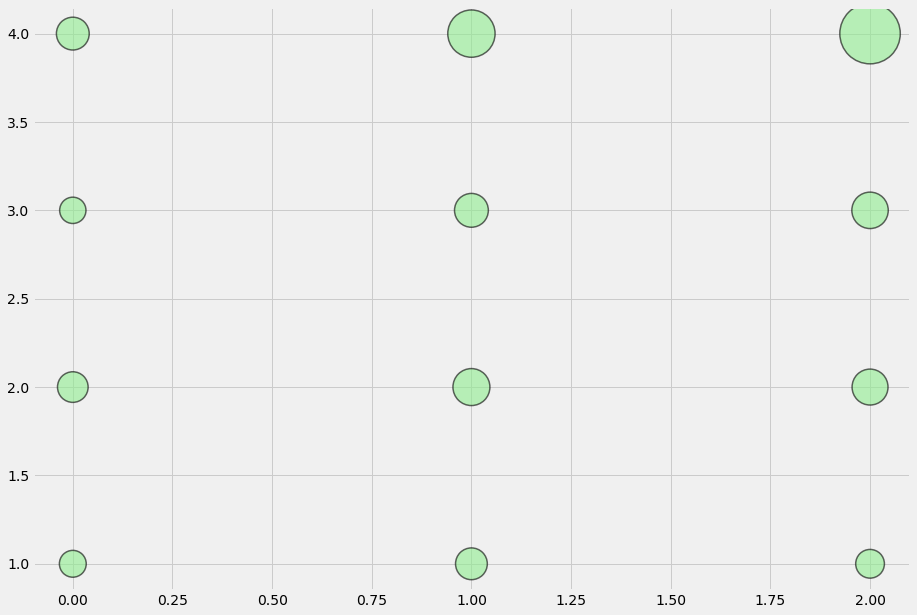

In [133]:
# Pared: variable ordinal
heads['walls'] = np.argmax(np.array(heads[['epared1', 'epared2', 'epared3']]),
                           axis = 1)

# heads = heads.drop(columns = ['epared1', 'epared2', 'epared3'])
plot_categoricals('walls', 'Target', heads)

In [134]:
# Techo: variable ordinal
heads['roof'] = np.argmax(np.array(heads[['etecho1', 'etecho2', 'etecho3']]),
                           axis = 1)
heads = heads.drop(columns = ['etecho1', 'etecho2', 'etecho3'])

# Piso: variable ordinal
heads['floor'] = np.argmax(np.array(heads[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)
# heads = heads.drop(columns = ['eviv1', 'eviv2', 'eviv3'])

## Construcción de variables

Además de mapear variables como características ordinales, podemos crear características nuevas a partir de datos existentes. Por ejemplo, podemos sumas las tres características anteriores para tener una medida de la calidad de la estructura del hogar.

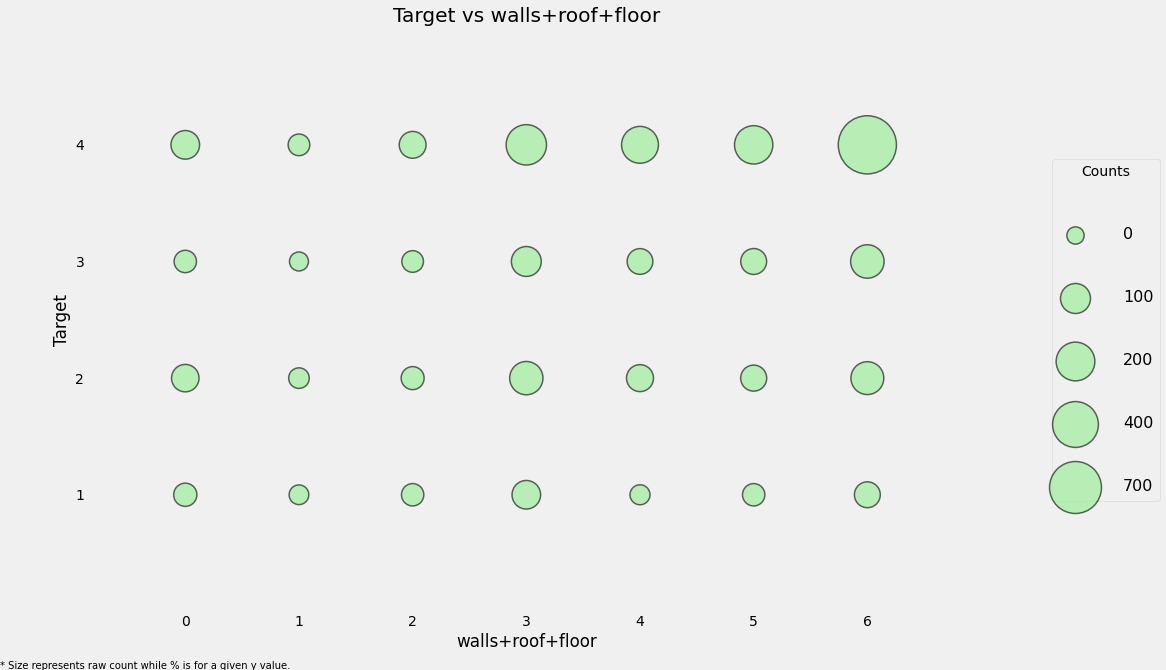

In [135]:
# Creamos variable nueva
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']

plot_categoricals('walls+roof+floor', 'Target', heads, annotate=False)

Esta nueva variable puede ser útil porque parece que hogares con un nivel 4 en la variable Target, también tienden a tener mayores valores en "calidad del hogar". También podemos mirar lo anterior en una tabla para obtener detalles.

In [136]:
counts = pd.DataFrame(heads.groupby(['walls+roof+floor'])['Target'].value_counts(normalize = True)).rename(columns = {'Target': 'Normalized Count'}).reset_index()
counts.head()

,walls+roof+floor,Target,Normalized Count
0,0,4.0,0.376404
1,0,2.0,0.320225
2,0,1.0,0.162921
3,0,3.0,0.140449
4,1,4.0,0.323529


La próxima variable será un `warning` sobre la calidad del hogar. Será un valor negativo, con valor -1 cuando no hay un water, electricidad, suelo, servicios de agua o techo.

In [137]:
# Sin water, electricidad, suelo, servicios de agua o techo.
heads['warning'] = 1 * (heads['sanitario1'] + 
                         (heads['elec'] == 0) + 
                         heads['pisonotiene'] + 
                         heads['abastaguano'] + 
                         (heads['cielorazo'] == 0))

Podemos seguir usando nuestra función `plot_categoricals` para visualizar estar relaciones, pero `seaborn` también tiene buenas opciones de visualización para variables categóricas. Una es el `violinplot` que muestra la distribución de una variable en el eje y el ancho indica el número de observaciones en esa categoría.

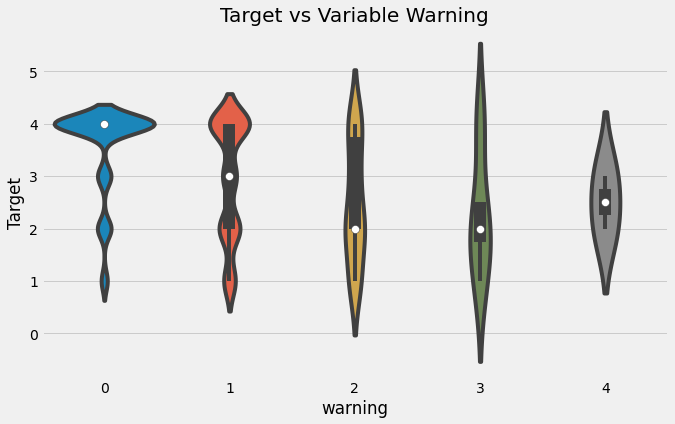

In [138]:
plt.figure(figsize = (10, 6))
sns.violinplot(x = 'warning', y = 'Target', data = heads);
plt.title('Target vs Variable Warning');

TypeError: annotate() missing 1 required positional argument: 's'

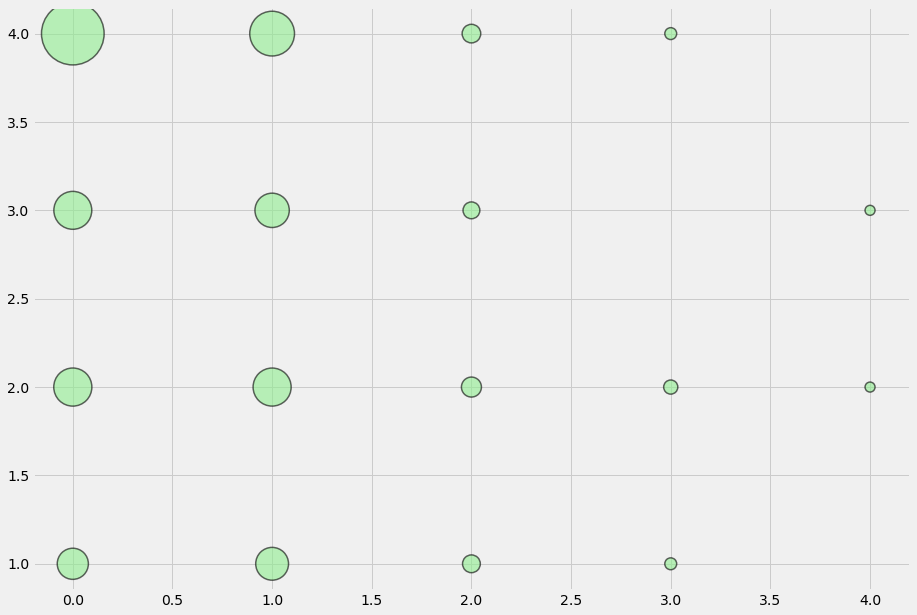

In [139]:
plot_categoricals('warning', 'Target', data = heads)

El plot tipo violín no es tan bueno porque suaviza la variable categórica de tal manera que se ve como si la variable Target pudiera tomar valores más pequeños o más grandes de los que puede tomar realmente. Sin embargo, podemos ver que hay una alta concentracion de hogares sin warning y que están en el nivel más extremo de pobreza. Pareciera que esta podría ser una variable útol, pero no sabremos bien hasta que modelemos.

La última característica a nivel hogar que crearemos por ahora es un `bonus` donde una familia obtiene un punto por tener un refrigerador, un computador, una tablet y un televisor.

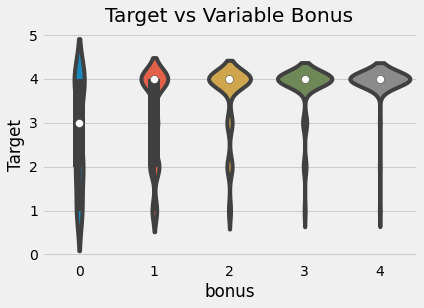

In [140]:
# Tiene un refrigerador, un computador, una tablet o un televisor.
heads['bonus'] = 1 * (heads['refrig'] + 
                      heads['computer'] + 
                      (heads['v18q1'] > 0) + 
                      heads['television'])

sns.violinplot('bonus', 'Target', data = heads,
                figsize = (10, 6));
plt.title('Target vs Variable Bonus');

## Cracterísticas individuales

Otras variables que podemos crear son las cantidades de ciertas mediciones por persona en el hogar.

In [141]:
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

## Explorando variables a nivel hogar

Luego de otodo esto, miraremos a la relación entre las variables a nivel hogar y la variable Target. 

### Midiendo relaciones entre variables

Usaremos dos mediciones de relaciones entre variables:

1. Correlación de Pearson: de -1 a 1 midiendo la relación lineal entre dos variables
2. Correlación de Spearman: de -1 a 1 midiendo la relación monotónica entre dos variables


In [142]:
from scipy.stats import spearmanr

In [144]:
def plot_corrs(x, y):
    """Plot data and show the spearman and pearson correlation."""
    
    # Calculamos correlaciones
    spr = spearmanr(x, y).correlation
    pcr = np.corrcoef(x, y)[0, 1]
    
    # Scatter plot
    data = pd.DataFrame({'x': x, 'y': y})
    plt.figure( figsize = (6, 4))
    sns.regplot('x', 'y', data = data, fit_reg = False);
    plt.title(f'Spearman: {round(spr, 2)}; Pearson: {round(pcr, 2)}');

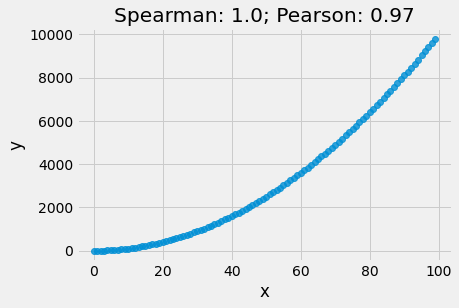

In [145]:
x = np.array(range(100))
y = x ** 2

plot_corrs(x, y)

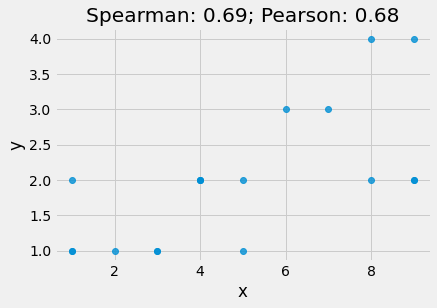

In [146]:
x = np.array([1, 1, 1, 2, 3, 3, 4, 4, 4, 5, 5, 6, 7, 8, 8, 9, 9, 9])
y = np.array([1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 3, 3, 2, 4, 2, 2, 4])

plot_corrs(x, y)

En la mayoría de los casos, los valores son bastante similares

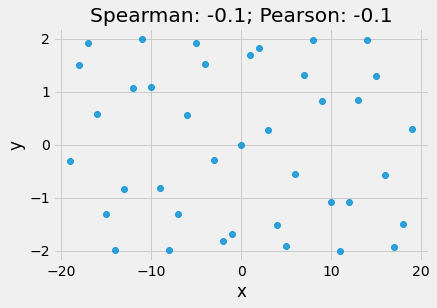

In [147]:
x = np.array(range(-19, 20))
y = 2 * np.sin(x)

plot_corrs(x, y)

Calculemos la correlación de Pearson entre cada variable y la variable Target

In [149]:
# Use only training data
train_heads = heads.loc[heads['Target'].notnull(), :].copy()

pcorrs = pd.DataFrame(train_heads.corr()['Target'].sort_values()).rename(columns = {'Target': 'pcorr'}).reset_index()
pcorrs = pcorrs.rename(columns = {'index': 'variable'})

print('Variables que correlacionan más negativamente:')
print(pcorrs.head())

print('\nVariables que correlacionan más positivamente:')
print(pcorrs.dropna().tail())

Variables que correlacionan más negativamente:
       variable     pcorr
0       warning -0.301791
1     hogar_nin -0.266309
2          r4t1 -0.260917
3  overcrowding -0.234954
4         eviv1 -0.217908

Variables que correlacionan más positivamente:
              variable     pcorr
97   phones-per-capita  0.299026
98               floor  0.307605
99    walls+roof+floor  0.332446
100           meaneduc  0.333652
101             Target  1.000000


A mayores niveles de `warning`, el nivel de pobreza también tiende a aumentar (menor puntaje en la variable Target). Lo mismo ocurre con la variable de cantidad de niños por hogar `hogar_nin`, donde a mayor cantidad de niños en el hogar mayores son los niveles de pobreza.

En las correlaciones positivas, destaca que la educación promedio de los adultos de hogar `meaneduc` se asocia a menores niveles de pobreza (mayores puntuaciones en esta variable).

Una guía general para interpretar los índices de correlación es la siguiente:

*  .00-.19 “muy débil”
*  .20-.39 “débil”
*  .40-.59 “moderada”
*  .60-.79 “fuerte”
*  .80-1.0 “muy fuerte”

Hay algunas correlaciones débiles, que esperamos que el modelo logre aprender a usar para poder predecir la variable Target.

Ahora vayamos a la correlación de Spearman

In [152]:
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

feats = []
scorr = []
pvalues = []

# Iteramos por cada columna
for c in heads:
    # Solo válido para números
    if heads[c].dtype != 'object':
        feats.append(c)
        
        # Calculamos correlación Spearman
        scorr.append(spearmanr(train_heads[c], train_heads['Target']).correlation)
        pvalues.append(spearmanr(train_heads[c], train_heads['Target']).pvalue)

scorrs = pd.DataFrame({'variable': feats, 'scorr': scorr, 'pvalue': pvalues}).sort_values('scorr')

La correlación de Spearman también tiene asociado un valor _p_, que debe ser corregido ya que estamos haciendo múltiples comparaciones. Así, usaremos la corrección de Bonferroni, que implica dividir el valor _p_ por la cantidad de comparaciones realizadas.

In [151]:
print('Variables que correlacionan más negativamente:')
print(scorrs.head())
print('\nVariables que correlacionan más positivamente:')
print(scorrs.dropna().tail())

Variables que correlacionan más negativamente:
      variable     scorr        pvalue
97     warning -0.307326  4.682829e-66
68  dependency -0.281516  2.792620e-55
85   hogar_nin -0.236225  5.567218e-39
80        r4t1 -0.219226  1.112230e-33
49       eviv1 -0.217803  2.952571e-33

Variables que correlacionan más positivamente:
             variable     scorr        pvalue
23          cielorazo  0.300996  2.611808e-63
95              floor  0.309638  4.466091e-67
99  phones-per-capita  0.337377  4.760104e-80
96   walls+roof+floor  0.338791  9.539346e-81
0              Target  1.000000  0.000000e+00


En su mayoría, ambos métodos (Pearson y Spearman) coinciden. Solo por curiosidad, podemos observar las variables en las que ambos coeficientes discrepan más.

In [153]:
corrs = pcorrs.merge(scorrs, on = 'variable')
corrs['diff'] = corrs['pcorr'] - corrs['scorr']

corrs.sort_values('diff').head()

,variable,pcorr,scorr,pvalue,diff
77,rooms-per-capita,0.152185,0.223303,6.521453e-35,-0.071119
85,v18q1,0.197493,0.244200,1.282664e-41,-0.046708
87,tablets-per-capita,0.204638,0.248642,3.951568e-43,-0.044004
2,r4t1,-0.260917,-0.219226,1.112230e-33,-0.041691
97,phones-per-capita,0.299026,0.337377,4.760104e-80,-0.038351


In [154]:
corrs.sort_values('diff').dropna().tail()

,variable,pcorr,scorr,pvalue,diff
57,techozinc,0.014357,0.003404,8.528369e-01,0.010954
49,hogar_mayor,-0.025173,-0.041722,2.290994e-02,0.016549
88,edjefe,0.235687,0.214736,2.367521e-32,0.020951
66,edjefa,0.052310,0.005114,7.804715e-01,0.047197
17,dependency,-0.126465,-0.281516,2.792620e-55,0.155051


La mayor discrepancia está en la variable `dependency`. Podemos hacer un scatterplot entre esta variable y la variable `Target` para mirar su relación. 

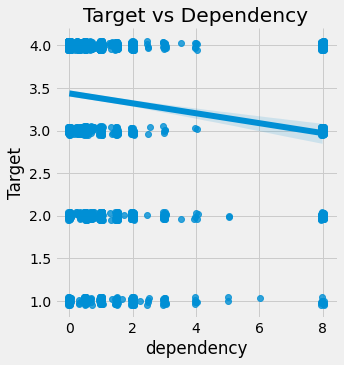

In [155]:
sns.lmplot('dependency', 'Target', fit_reg = True, data = train_heads, x_jitter=0.05, y_jitter=0.05);
plt.title('Target vs Dependency');

Es una relación levemente negativa. `dependency` es el número de integrantes del hogar que son dependientes dividido por el número de integrantes del hogar que son independientes. Tener más integrantes que no trabajan lleva a mayores niveles de pobreza.

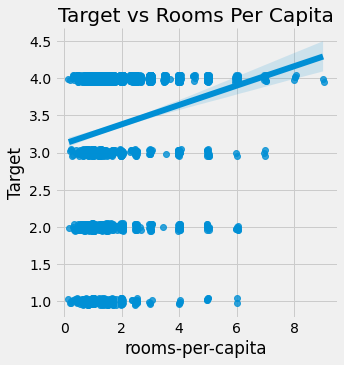

In [156]:
sns.lmplot('rooms-per-capita', 'Target', fit_reg = True, data = train_heads, x_jitter=0.05, y_jitter=0.05);
plt.title('Target vs Rooms Per Capita');

#### Correlaciones: Mapa de calor

Para esta visualización elegiremos 7 variables y observaremos cómo correlacionan con la variable Target

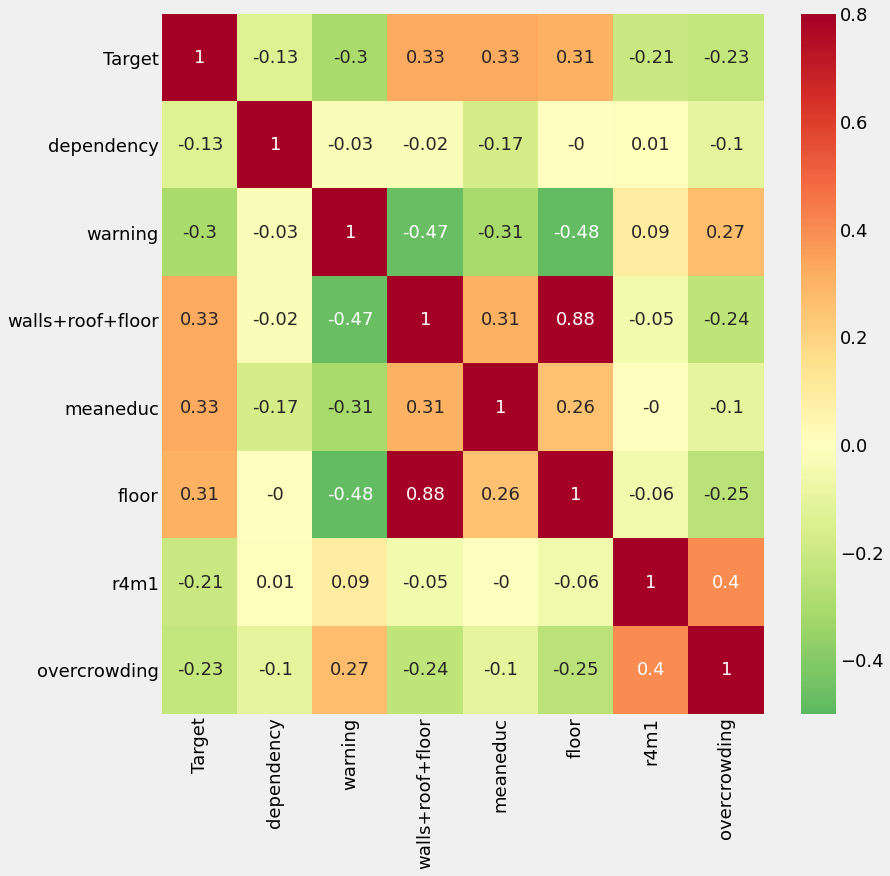

In [158]:
variables = ['Target', 'dependency', 'warning', 'walls+roof+floor', 'meaneduc',
             'floor', 'r4m1', 'overcrowding']

# Calculamos correlaciones
corr_mat = train_heads[variables].corr().round(2)

# Mapa de calor correlaciones
plt.rcParams['font.size'] = 18
plt.figure(figsize = (12, 12))
sns.heatmap(corr_mat, vmin = -0.5, vmax = 0.8, center = 0, 
            cmap = plt.cm.RdYlGn_r, annot = True);

Este plot nos muestra que hay un número de variables que tienen una correlación débil con Target, pero también hay variables que correlacionan fuertemente con otras variables que no son la variable Target (como `floor` y `walls+roof+floor`) lo cual nos podría llevar a problemas de colinearidad. 

### Más visualizaciónes

Para la última exploración, plotearemos algunas de las variables que más correlacionan con la variable Target. Se observa un scatterplot en el triángulo superior, el estimado de la densidad del kernel en la diagonal (kde), y plot 2D de KDE en el triángulo inferior.

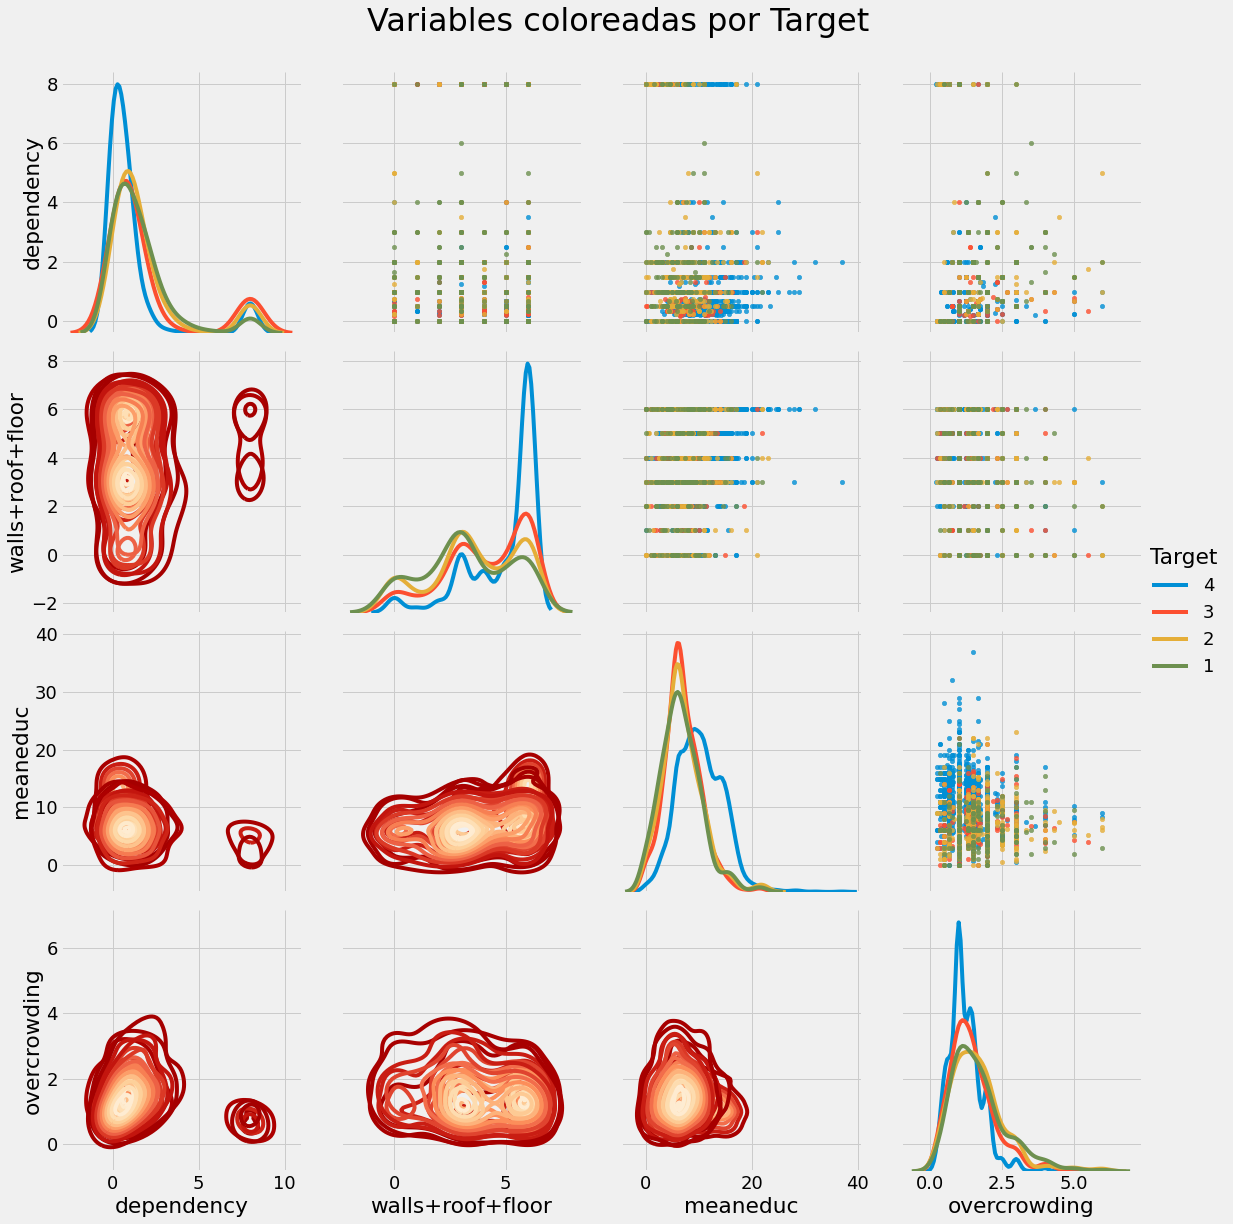

In [159]:
import warnings
warnings.filterwarnings('ignore')

# Copiamos los datos para graficar
plot_data = train_heads[['Target', 'dependency', 'walls+roof+floor',
                         'meaneduc', 'overcrowding']]

# creamos objeto parigrid
grid = sns.PairGrid(data = plot_data, size = 4, diag_sharey=False,
                    hue = 'Target', hue_order = [4, 3, 2, 1], 
                    vars = [x for x in list(plot_data.columns) if x != 'Target'])

# Arriba hay un scatterplot
grid.map_upper(plt.scatter, alpha = 0.8, s = 20)

# En la diagonal hay un histograma
grid.map_diag(sns.kdeplot)

# Abajo hay un gráfico de densidad
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);
grid = grid.add_legend()
plt.suptitle('Variables coloreadas por Target', size = 32, y = 1.05);

Dejaremos hasta aquí la ingeniería de variables. Tal vez queramos volver luego de probar los modelos

In [161]:
household_feats = list(heads.columns)

# Variables a nivel individual

Hay dos tipos de variables a nivel individual: Booleanas y ordinales.

In [162]:
ind = data[id_ + ind_bool + ind_ordered]
ind.shape

(33413, 40)

## Variables individuales redundantes

Repetimos el proceso de buscar las variables con mayor correlación entre ellas


In [163]:
# Creamos matriz de correlaciones
corr_matrix = ind.corr()

# Seleccionamos triángulo superior
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Encontramos el índice de las columnas que tienen una corr mayor a 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['female']

Solo es el opuesto de "masculino" por lo que podemos eliminar esta variable

In [164]:
ind = ind.drop(columns = 'male')

### Creando variables ordinales

Aquí nos enfocaremos en las variables `instlevel_` que indica el nivel de educación, `instlevel1` que indica sin educación, y `instlevel9` que indica posgrado. A partir de las tres crearemos una variable ordinal y luego eliminaremos las originales.

In [165]:
ind[[c for c in ind if c.startswith('instl')]].head()

,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0


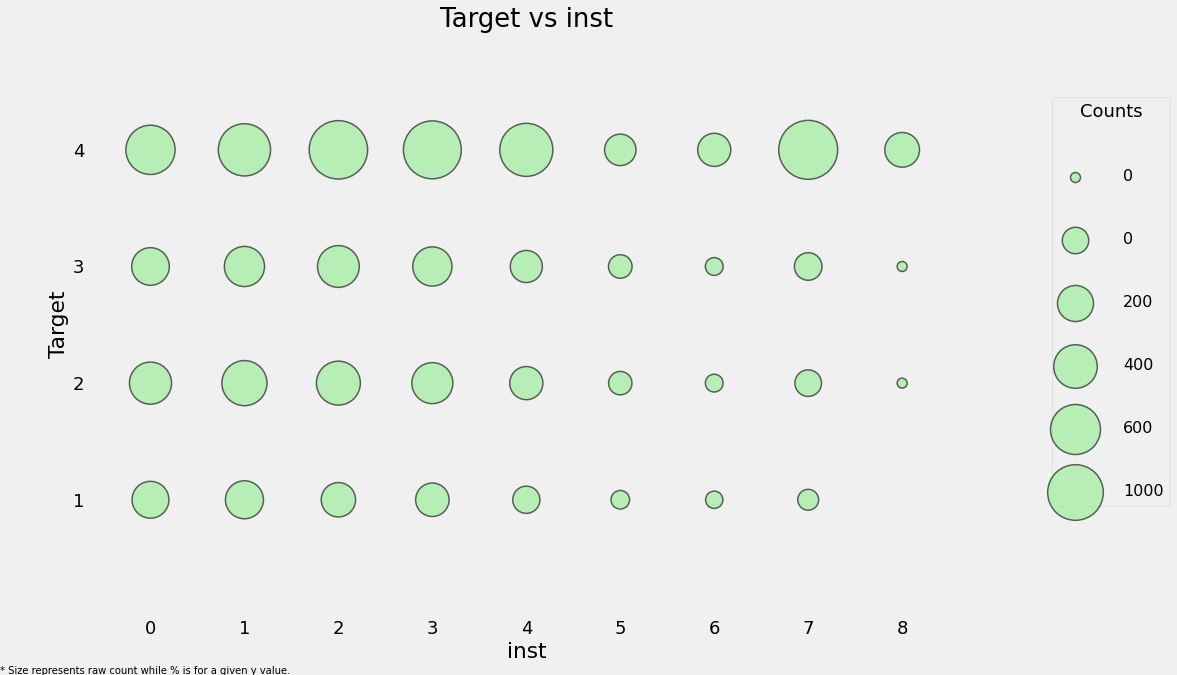

In [166]:
ind['inst'] = np.argmax(np.array(ind[[c for c in ind if c.startswith('instl')]]), axis = 1)

plot_categoricals('inst', 'Target', ind, annotate = False);

Mayores niveles de educación se asocian a menores niveles de pobreza

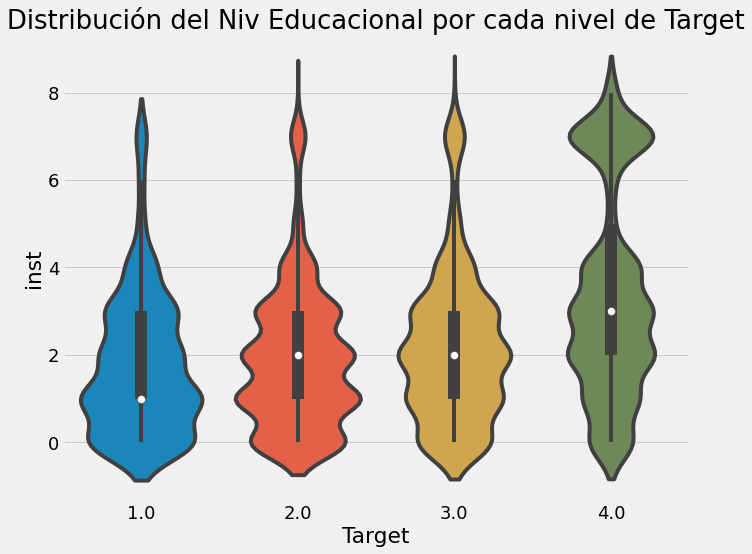

In [167]:
plt.figure(figsize = (10, 8))
sns.violinplot(x = 'Target', y = 'inst', data = ind);
plt.title('Distribución del Niv Educacional por cada nivel de Target');

In [169]:
# Eliminamos variables educación
# ind = ind.drop(columns = [c for c in ind if c.startswith('instlevel')])
ind.shape

(33413, 40)

### Construcción de características

Podemos crear por ejemplo una índice de años de educación dividido por la edad.

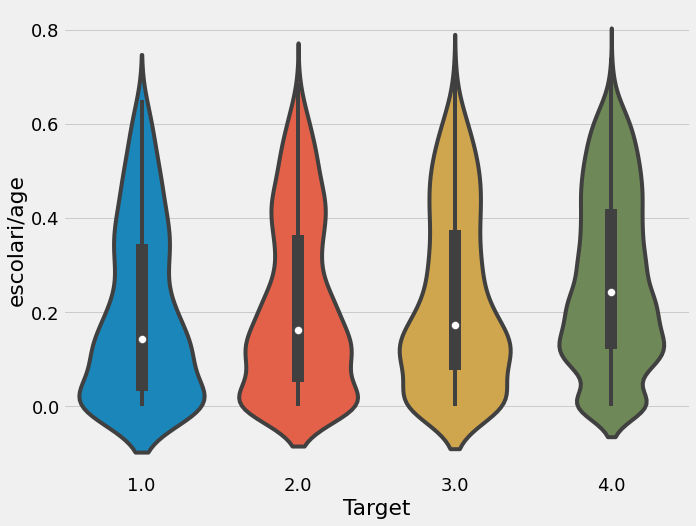

In [170]:
ind['escolari/age'] = ind['escolari'] / ind['age']

plt.figure(figsize = (10, 8))
sns.violinplot('Target', 'escolari/age', data = ind);

También podemos tomar nuestra nueva variable, `inst`, y dividirla por edad. Esta variable se llamará `tech`: que representa la combinación de tablets y teléfonos.

In [171]:
ind['inst/age'] = ind['inst'] / ind['age']
ind['tech'] = ind['v18q'] + ind['mobilephone']
ind['tech'].describe()

count    33413.000000
mean         1.214886
std          0.462567
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: tech, dtype: float64

## Ingeniería de variables por agregados

Para incorporar la data individual a la data por hogar, agregaremos por hogar. La forma más simple de hacer eso es usar  `groupby` para agrupar por `idhogar` y luego hacer un `agg` de los datos. Para agregar datos de variables continuas y ordinales, podemos usar 6, 5 de las cuales están en pandas, y una de las cuales definiremos nosotros mismos `range_`. El agregado de Booleanas se puede hacer de la misma forma, pero generaría muchas columnas redundantes, de las cuales nos queremos deshacer. Entonces, haremos los agregados y luego nos devolveremos a borrar aquellas columnas redundantes.

In [173]:
# Definimos función
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'

# Agrupamos y armamos el agregado
ind_agg = ind.drop(columns = 'Target').groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

v18q                           dis                                 \
           min max sum count  std range_ min max sum count       std range_   
idhogar                                                                       
000a08204    1   1   3     3  0.0      0   0   0   0     3  0.000000      0   
000bce7c4    0   0   0     2  0.0      0   0   1   1     2  0.707107      1   
001845fb0    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  0.000000      0   
003123ec2    0   0   0     4  0.0      0   0   0   0     4  0.000000      0   

          female                                estadocivil1                \
             min max sum count       std range_          min max sum count   
idhogar                                                                      
000a08204      0   1   1     3  0.577350      1            0   1   1     3   
000bce7c4      0   1   1     2  0.707107      1            0   0   0     2   
001845fb0      0   1   2     4  0.577350      1            0   0   0     4   
001ff74ca      1   1   2     2  0.000000      0            0   1   1     2   
003123ec2      0   1   1     4  0.500000      1            0   1   2     4   

                           estadocivil2                                \
                std range_          min max sum count      std range_   
idhogar                                                                 
000a08204  0.577350      1            0   1   2     3  0.57735      1   
000bce7c4  0.000000      0            0   0   0     2  0.00000      0   
001845fb0  0.000000      0            0   1   2     4  0.57735      1   
001ff74ca  0.707107      1            0   0   0     2  0.00000      0   
003123ec2  0.577350      1            0   1   2     4  0.57735      1   

          estadocivil3                           estadocivil4                \
                   min max sum count  std range_          min max sum count   
idhogar                                                                       
000a08204            0   0   0     3  0.0      0            0   0   0     3   
000bce7c4            1   1   2     2  0.0      0            0   0   0     2   
001845fb0            0   0   0     4  0.0      0            0   0   0     4   
001ff74ca            0   0   0     2  0.0      0            0   0   0     2   
003123ec2            0   0   0     4  0.0      0            0   0   0     4   

                      estadocivil5                                 \
           std range_          min max sum count       std range_   
idhogar                                                             
000a08204  0.0      0            0   0   0     3  0.000000      0   
000bce7c4  0.0      0            0   0   0     2  0.000000      0   
001845fb0  0.0      0            0   0   0     4  0.000000      0   
001ff74ca  0.0      0            0   1   1     2  0.707107      1   
003123ec2  0.0      0            0   0   0     4  0.000000      0   

          estadocivil6                           estadocivil7                \
                   min max sum count  std range_          min max sum count   
idhogar                                                                       
000a08204            0   0   0     3  0.0      0            0   0   0     3   
000bce7c4            0   0   0     2  0.0      0            0   0   0     2   
001845fb0            0   0   0     4  0.0      0            0   1   2     4   
001ff74ca            0   0   0     2  0.0      0            0   0   0     2   
003123ec2            0   0   0     4  0.0      0            0   0   0     4   

                          parentesco1                                 \
               std range_         min max sum count       std range_   
idhogar                                                                
000a08204  0.00000      0           0   1   1     3  0.577350      1   
000bce7c4  0.00000      0           0   1   1     2  0.70710

Pasamos de 30 a 180 variables. Ahora renombraremos las columnas

In [174]:
# Renombramos columnas
new_col = []
for c in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        new_col.append(f'{c}-{stat}')
        
ind_agg.columns = new_col
ind_agg.head()

,v18q-min,v18q-max,v18q-sum,v18q-count,v18q-std,v18q-range_,dis-min,dis-max,dis-sum,dis-count,dis-std,dis-range_,female-min,female-max,female-sum,female-count,female-std,female-range_,estadocivil1-min,estadocivil1-max,estadocivil1-sum,estadocivil1-count,estadocivil1-std,estadocivil1-range_,estadocivil2-min,estadocivil2-max,estadocivil2-sum,estadocivil2-count,estadocivil2-std,estadocivil2-range_,estadocivil3-min,estadocivil3-max,estadocivil3-sum,estadocivil3-count,estadocivil3-std,estadocivil3-range_,estadocivil4-min,estadocivil4-max,estadocivil4-sum,estadocivil4-count,estadocivil4-std,estadocivil4-range_,estadocivil5-min,estadocivil5-max,estadocivil5-sum,estadocivil5-count,estadocivil5-std,estadocivil5-range_,estadocivil6-min,estadocivil6-max,estadocivil6-sum,estadocivil6-count,estadocivil6-std,estadocivil6-range_,estadocivil7-min,estadocivil7-max,estadocivil7-sum,estadocivil7-count,estadocivil7-std,estadocivil7-range_,parentesco1-min,parentesco1-max,parentesco1-sum,parentesco1-count,parentesco1-std,parentesco1-range_,parentesco2-min,parentesco2-max,parentesco2-sum,parentesco2-count,parentesco2-std,parentesco2-range_,parentesco3-min,parentesco3-max,parentesco3-sum,...,instlevel5-count,instlevel5-std,instlevel5-range_,instlevel6-min,instlevel6-max,instlevel6-sum,instlevel6-count,instlevel6-std,instlevel6-range_,instlevel7-min,instlevel7-max,instlevel7-sum,instlevel7-count,instlevel7-std,instlevel7-range_,instlevel8-min,instlevel8-max,instlevel8-sum,instlevel8-count,instlevel8-std,instlevel8-range_,instlevel9-min,instlevel9-max,instlevel9-sum,instlevel9-count,instlevel9-std,instlevel9-range_,mobilephone-min,mobilephone-max,mobilephone-sum,mobilephone-count,mobilephone-std,mobilephone-range_,rez_esc-min,rez_esc-max,rez_esc-sum,rez_esc-count,rez_esc-std,rez_esc-range_,escolari-min,escolari-max,escolari-sum,escolari-count,escolari-std,escolari-range_,age-min,age-max,age-sum,age-count,age-std,age-range_,inst-min,inst-max,inst-sum,inst-count,inst-std,inst-range_,escolari/age-min,escolari/age-max,escolari/age-sum,escolari/age-count,escolari/age-std,escolari/age-range_,inst/age-min,inst/age-max,inst/age-sum,inst/age-count,inst/age-std,inst/age-range_,tech-min,tech-max,tech-sum,tech-count,tech-std,tech-range_
idhogar,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000a08204,1,1,3,3,0.0,0,0,0,0,3,0.000000,0,0,1,1,3,0.577350,1,0,1,1,3,0.577350,1,0,1,2,3,0.57735,1,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.000000,0,0,0,0,3,0.0,0,0,0,0,3,0.00000,0,0,1,1,3,0.577350,1,0,1,1,3,0.577350,1,0,1,1,...,3,0.0,0,0,0,0,3,0.0,0,0,0,0,3,0.0,0,0,1,2,3,0.577350,1,0,0,0,3,0.0,0,1,1,3,3,0.0,0,0.0,0.0,0.0,3,0.0,0.0,0,14,26,3,7.571878,14,4,30,62,3,14.468356,26,0,7,14,3,4.041452,7,0.000000,0.500000,0.900000,3,0.264575,0.500000,0.000000,0.250000,0.483333,3,0.139775,0.250000,2,2,6,3,0.0,0
000bce7c4,0,0,0,2,0.0,0,0,1,1,2,0.707107,1,0,1,1,2,0.707107,1,0,0,0,2,0.000000,0,0,0,0,2,0.00000,0,1,1,2,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.000000,0,0,0,0,2,0.0,0,0,0,0,2,0.00000,0,0,1,1,2,0.707107,1,0,1,1,2,0.707107,1,0,0,0,...,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.0,0,0,0,0,2,0.000000,0,0,0,0,2,0.0,0,1,1,2,2,0.0,0,0.0,0.0,0.0,2,0.0,0.0,0,5,5,2,3.535534,5,60,63,123,2,2.121320,3,0,1,1,2,0.707107,1,0.000000,0.083333,0.083333,2,0.058926,0.083333,0.000000,0.016667,0.016667,2,0.011785,0.016667,1,1,2,2,0.0,0
001845fb0,0,0,0,4,0.0,0,0,0,0,4,0.000000,0,0,1,2,4,0.577350,1,0,0,0,4,0.000000,0,0,1,2,4,0.57735,1,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,0,0,4,0.000000,0,0,0,0,4,0.0,0,0,1,2,4,0.57735,1,0,1,1,4,0.500000,1,0,1,1,4,0.500000,1,0,1,2,...,4,0.5,1,0,0,0,4,0.0,0,0,0,0,4,0.0,0,0,1,1,4,0.500000,1,0,0,0,4,0.0,0,1,1,4,4,0.0,0,0.0,0.0,0.0,3,0.0,0.0,6,14,41,4,3.304038,8,19,52,142,4,16.421531,33,2,7,16,4,2.160247,5,0.115385,0.526316,1.397906,4,0.183106,0.410931,0.038462,0.166667,0.511959,4,0.060123,0.128205,1,1,4,4,0.0,0
001ff74ca,1,1,2,2,0.0,0,0,0,0,2,0.000000,0,1,1,2,2,0.000000,0,0,1,1,2,0.707107,1,0,0,0,2,0.00

In [175]:
ind_agg.iloc[:, [0, 1, 2, 3, 6, 7, 8, 9]].head()

,v18q-min,v18q-max,v18q-sum,v18q-count,dis-min,dis-max,dis-sum,dis-count
idhogar,,,,,,,,
000a08204,1,1,3,3,0,0,0,3
000bce7c4,0,0,0,2,0,1,1,2
001845fb0,0,0,0,4,0,0,0,4
001ff74ca,1,1,2,2,0,0,0,2
003123ec2,0,0,0,4,0,0,0,4


### Selección de características

Nuevamente eliminaremos aquellas variables que correlacionan entre sí con un coeficiente de correlación mayor a 0.95

In [176]:
# Creamos matriz de correlaciones
corr_matrix = ind_agg.corr()

# Seleccionamos triángulo superior
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Encontramos el índice de las columnas con una corr mayor a 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

print(f'Hay {len(to_drop)} columnas correlacionadas que eliminar.')

Hay 111 columnas correlacionadas que eliminar.


Eliminaremos las columnas y uniremos este dataset al dataset con la información por hogares.

In [177]:
ind_agg = ind_agg.drop(columns = to_drop)
ind_feats = list(ind_agg.columns)

# Unimos al id por hogar
final = heads.merge(ind_agg, on = 'idhogar', how = 'left')

print('Forma final de los datos: ', final.shape)

Forma final de los datos:  (10307, 228)


In [178]:
final.head()

,Id,idhogar,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,eviv1,eviv2,eviv3,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,v2a1-missing,v2a1,dependency,edjefe,edjefa,meaneduc,overcrowding,...,parentesco6-max,parentesco6-sum,parentesco7-min,parentesco7-max,parentesco8-min,parentesco8-max,parentesco9-min,parentesco9-max,parentesco9-sum,parentesco10-min,parentesco10-max,parentesco11-min,parentesco11-max,parentesco11-sum,parentesco12-min,parentesco12-max,parentesco12-sum,instlevel1-min,instlevel1-max,instlevel1-sum,instlevel2-min,instlevel2-max,instlevel2-sum,instlevel2-std,instlevel3-min,instlevel3-max,instlevel3-sum,instlevel3-std,instlevel4-min,instlevel4-max,instlevel4-sum,instlevel4-std,instlevel5-min,instlevel5-max,instlevel5-sum,instlevel6-min,instlevel6-max,instlevel7-min,instlevel7-max,instlevel8-min,instlevel8-max,instlevel8-sum,instlevel8-std,instlevel9-min,instlevel9-max,mobilephone-min,mobilephone-std,mobilephone-range_,rez_esc-min,rez_esc-max,escolari-min,escolari-max,escolari-sum,escolari-std,escolari-range_,age-min,age-max,age-sum,age-std,age-range_,inst-max,inst-std,inst-range_,escolari/age-min,escolari/age-max,escolari/age-sum,escolari/age-std,escolari/age-range_,inst/age-max,inst/age-std,inst/age-range_,tech-min,tech-sum,tech-std,tech-range_
0,ID_279628684,21eb7fcc1,4.0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,190000.0,0.0,10.0,0.0,10.0,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,1,1,1,NaN,0,0,0,0,0,0,0,0,0,0,NaN,0,0,1,NaN,0,0.0,0.0,10,10,10,NaN,0,43,43,43,NaN,0,3,NaN,0,0.232558,0.232558,0.232558,NaN,0.000000,0.069767,NaN,0.000000,1,1,NaN,0
1,ID_f29eb3ddd,0e5d7a658,4.0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,135000.0,8.0,12.0,0.0,12.0,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,0,0,0,0,1,1,1,NaN,0,0,1,NaN,0,0.0,0.0,12,12,12,NaN,0,67,67,67,NaN,0,7,NaN,0,0.179104,0.179104,0.179104,NaN,0.000000,0.104478,NaN,0.000000,2,2,NaN,0
2,ID_68de51c94,2c7317ea8,4.0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,False,0.0,8.0,0.0,11.0,11.0,0.500000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,1,1,1,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,0.0,0.0,11,11,11,NaN,0,92,92,92,NaN,0,4,NaN,0,0.119565,0.119565,0.119565,NaN,0.000000,0.043478,NaN,0.000000,0,0,NaN,0
3,ID_ec05b1a7b,2b58d945f,4.0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,180000.0,1.0,11.0,0.0,11.0,1.333333,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.5,0,0,0,0.0,0,1,1,0.5,0,1,2,0,0,0,0,0,0,0,0.0,0,0,1,0.0,0,0.0,1.0,2,11,33,4.272002,9,8,38,100,14.899664,30,4,1.414214,3,0.250000,0.529412,1.366183,0.126943,0.279412,0.176471,0.033010,0.071207,2,8,0.0,0
4,ID_1284f8aad,d6dae86b7,4.0,1,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,False,130000.0,1.0,9.0,0.0,10.0,4.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0.5,0,0,0,0.0,0,1,1,0.5,0,1,1,0,0,0,0,0,0,0,0.0,0,0,1,0.0,0,0.0,1.0,0,11,23,5.123475,11,7,30,76,11.690452,23,4,1.825742,4,0.000000,0.392857,0.965584,0.168946,0.392857,0.142857,0.060063,0.142857,1,4,0.0,0


### Exploración final de los datos

 

In [179]:
corrs = final.corr()['Target']

In [180]:
corrs.sort_values().head()

warning          -0.301791
instlevel2-sum   -0.297868
instlevel1-sum   -0.271204
hogar_nin        -0.266309
r4t1             -0.260917
Name: Target, dtype: float64

In [181]:
corrs.sort_values().dropna().tail()

walls+roof+floor    0.332446
meaneduc            0.333652
inst-max            0.368229
escolari-max        0.373091
Target              1.000000
Name: Target, dtype: float64

Vemos que algunas de las variables que creamos están fuertemente correlacionadas con la variable Target. Pero de ahí a que estas variables sean útiles, no lo sabremos hasta que modelemos.

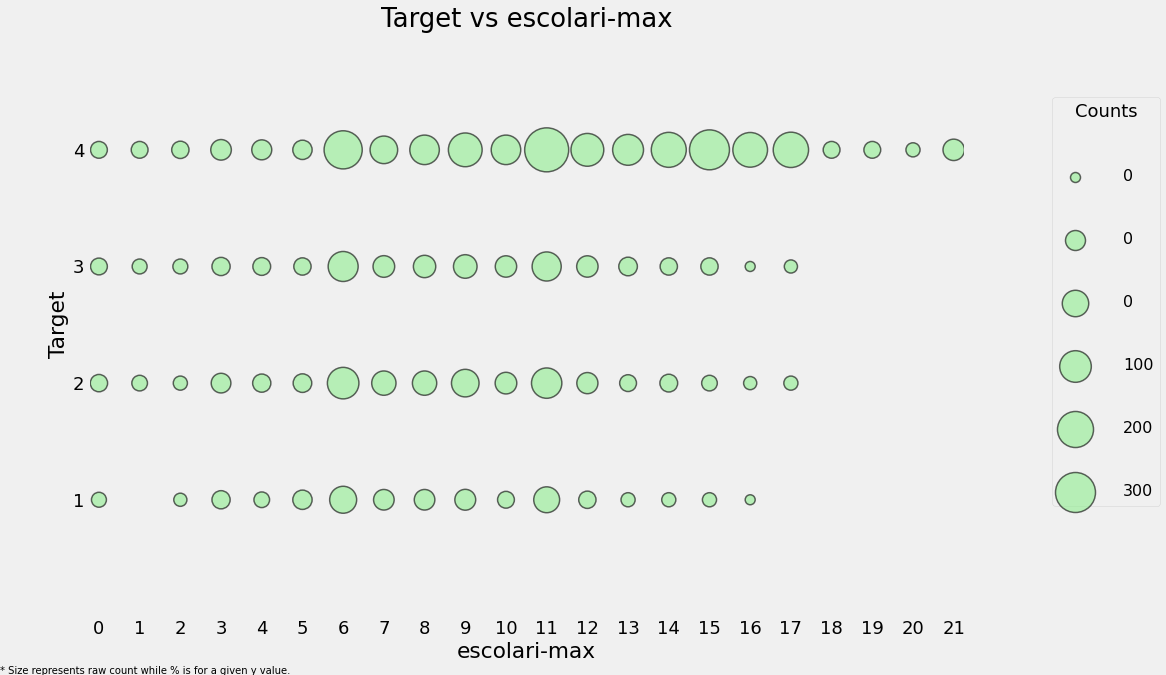

In [182]:
plot_categoricals('escolari-max', 'Target', final, annotate=False);

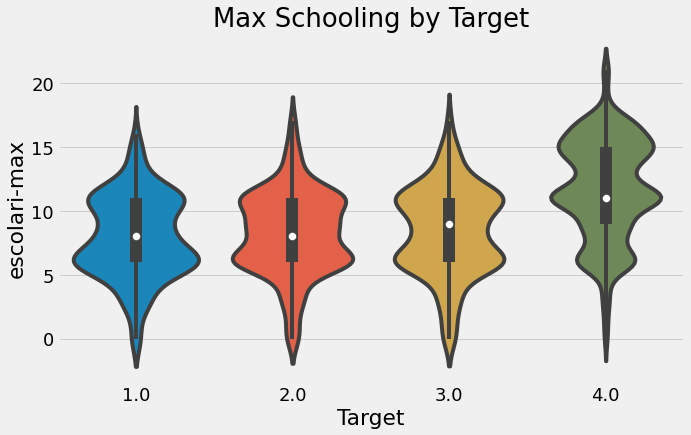

In [183]:
plt.figure(figsize = (10, 6))
sns.violinplot(x = 'Target', y = 'escolari-max', data = final);
plt.title('Max Schooling by Target');

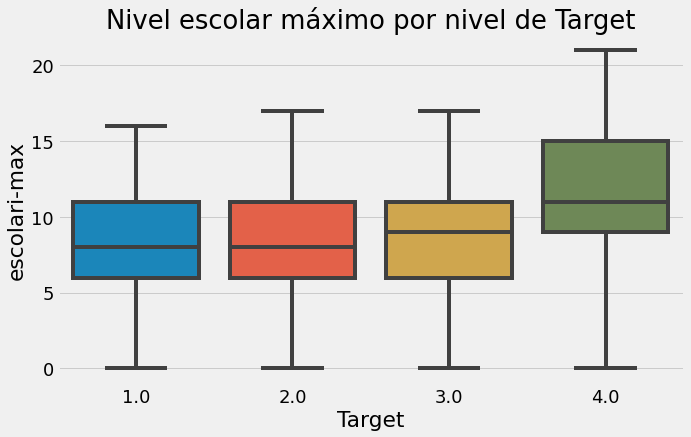

In [184]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'escolari-max', data = final);
plt.title('Nivel escolar máximo por nivel de Target');

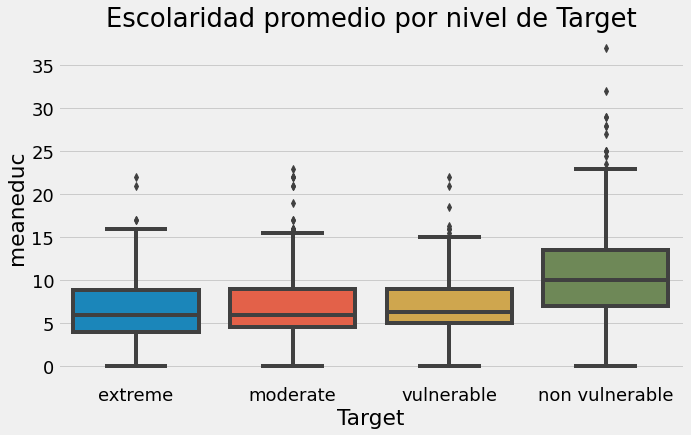

In [185]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'meaneduc', data = final);
plt.xticks([0, 1, 2, 3], poverty_mapping.values())
plt.title('Escolaridad promedio por nivel de Target');

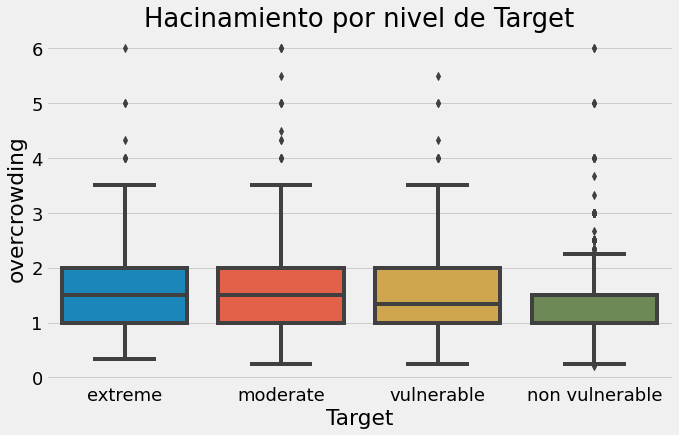

In [186]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'overcrowding', data = final);
plt.xticks([0, 1, 2, 3], poverty_mapping.values())
plt.title('Hacinamiento por nivel de Target');

Otra característica que puede ser útil es el género del individuo que encabeza el hogar. Ya que hicimos un agregado de los datos, tendremos que volver a los datos a nivel individual para encontrar esta información.

In [187]:
head_gender = ind.loc[ind['parentesco1'] == 1, ['idhogar', 'female']]
final = final.merge(head_gender, on = 'idhogar', how = 'left').rename(columns = {'female': 'female-head'})

In [188]:
final.groupby('female-head')['Target'].value_counts(normalize=True)

female-head  Target
0            4.0       0.682873
             2.0       0.136464
             3.0       0.123204
             1.0       0.057459
1            4.0       0.617369
             2.0       0.167670
             3.0       0.113500
             1.0       0.101462
Name: Target, dtype: float64

Cuando las mueres encabezan los hogares, estos hogares tienen una pequeña tendencia a mostrar mayores niveles de pobreza.

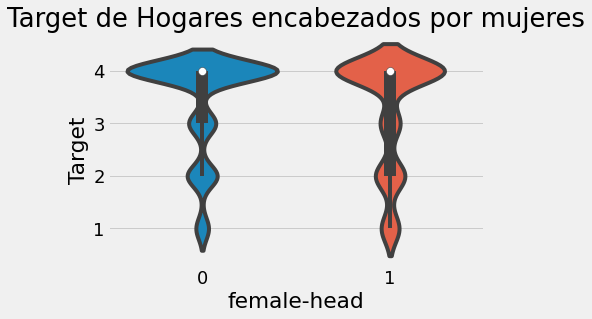

In [190]:
sns.violinplot(x = 'female-head', y = 'Target', data = final);
plt.title('Target de Hogares encabezados por mujeres');

También podemos observar la diferencia en el promedio de educación de acuerdo a si el hogar tiene o no una mujer que lo encabeza.

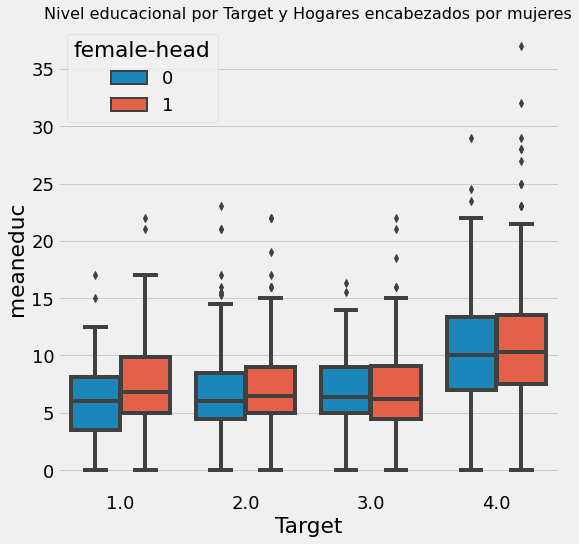

In [192]:
plt.figure(figsize = (8, 8))
sns.boxplot(x = 'Target', y = 'meaneduc', hue = 'female-head', data = final);
plt.title('Nivel educacional por Target y Hogares encabezados por mujeres', size = 16);

En cada punto de la variable `Target`, los hogares encabezados por mujeres tienden a tener mayores niveles de educación. Sin embargo, vimos que los hogares encabezados por mujeres tendían a sufrir de pobreza más extrema.

In [193]:
final.groupby('female-head')['meaneduc'].agg(['mean', 'count'])

,mean,count
female-head,,
0,8.968025,6384
1,9.237013,3903


El promedio de educación de los hogares encabezados por mujeres es levemente mayor que en los hogares encabezados por hombres.

# Modelos de Machine Learning

Para mostrar el proceso de modelamiento, usaremos Random Forest Classifier en Scikit-Learn. Esto probablemente no es lo mejor que hay en machine learning, pero nos permitirá establecer una base. Luego, intentaremos otros modelos incluyendo el poderoso Gradient Boosting Machine.

Para abordar nuestro modelo, usaremos una validación cruzada 10-folf sobre los datos de entrenamiento. Esto esencialmente va a entrenar y testear el modelo 10 veces, usando diferentes divisiones de los datos de entrenamiento. Este método es efectivo para estimar el desempeño del modelo en los datos de testeo. Queremos mirar el desempeño promedio en la validación cruzada y la desviación estándar para ver qué tanto cambian los valores entre trilas. Usaremos `F1 Macro` para evaluar desempeño.

In [197]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Armamos scorer para registrar las validaciones cruzadas
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

In [198]:
# Etiquetas para el entrenamiento
train_labels = np.array(list(final[final['Target'].notnull()]['Target'].astype(np.uint8)))

# Tomamos los datos de entrenamiento
train_set = final[final['Target'].notnull()].drop(columns = ['Id', 'idhogar', 'Target'])
test_set = final[final['Target'].isnull()].drop(columns = ['Id', 'idhogar', 'Target'])

submission_base = test[['Id', 'idhogar']].copy()

Como vamos a comprar varios modelos, queremos estandarizar las características (limitar el rango de cada columna para que sus valores fluctúen entre 0 y 1). Muchas veces esto no es necesario, pero cuando usamos modelos que dependen de la distancia de la métrica, como KNearest Neighbors o Support Vector Machine, es necesario estandarizar. Cuando comparamos diferentes modelos, siempre es más seguro tener valores estandarizados. También imputamos los valores perdidos con la mediana de cada variable.

Para hacer la imputación y estandarización en un paso, haremos un pipeline. Esto se usará para transformar los datos del dataset de entrenamiento y del de testeo.

In [199]:
features = list(train_set.columns)

pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

# Ajustamos y transformamos data de entrenamiento
train_set = pipeline.fit_transform(train_set)
test_set = pipeline.transform(test_set)

Ahora los datos no tienen valores perdidos y está estandarizada.

In [200]:
model = RandomForestClassifier(n_estimators=100, random_state=10, 
                               n_jobs = -1)
# Validación curzada (10)
cv_score = cross_val_score(model, train_set, train_labels, cv = 10, scoring = scorer)

print(f'10 Validación Cruzada, puntaje F1 = {round(cv_score.mean(), 4)} con desv.est = {round(cv_score.std(), 4)}')

10 Validación Cruzada, puntaje F1 = 0.3439 con desv.est = 0.0438


Este puntaje no es excelente, pero ya podremos mejorar!

## Ponderación de Importancia

Con modelo de árbol podemos mirar la importancia de cada variable, que mostrará un ranking relativo de la utilidad de cada variable para el modelo. 

Para hacer esto necesitamos usar el dataset de entrenamiento completo, no como en el paso anterior.

In [201]:
model.fit(train_set, train_labels)

# Importancia de las variables a dataframe
feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importances.head()

,feature,importance
0,hacdor,0.000643
1,hacapo,0.000283
2,v14a,0.000460
3,refrig,0.001798
4,paredblolad,0.006024


Aquí hay una función que permite visualizar la importancia relativa de cada variable.

In [202]:
def plot_feature_importances(df, n = 10, threshold = None):
    """Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
    
        n (int): Number of most important features to plot. Default is 15.
    
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    
    """
    plt.style.use('fivethirtyeight')
    
    # Ordenamos de mayor a menos importancia
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalizamos la importancia de las variables para que sume 1, y calculamos importancia acumulada
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Gráfico de barras de n variables de mayor importanca
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Importancia Normalizada', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Variables más importantes', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Plot importancia acumulada
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Cantidad de variables', size = 16); plt.ylabel('Importancia acumulada', size = 16); 
        plt.title('Importancia Acumulada de Variables', size = 18);
        
        # Cantidad de variables necesarias para alcanzar el umbral de importancia acumulada
        # Índice (tiene que sumar 1)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Sumamos linea vertical al gráfico
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} variables dan cuenta del {:.0f}% de importancia acumulada.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df


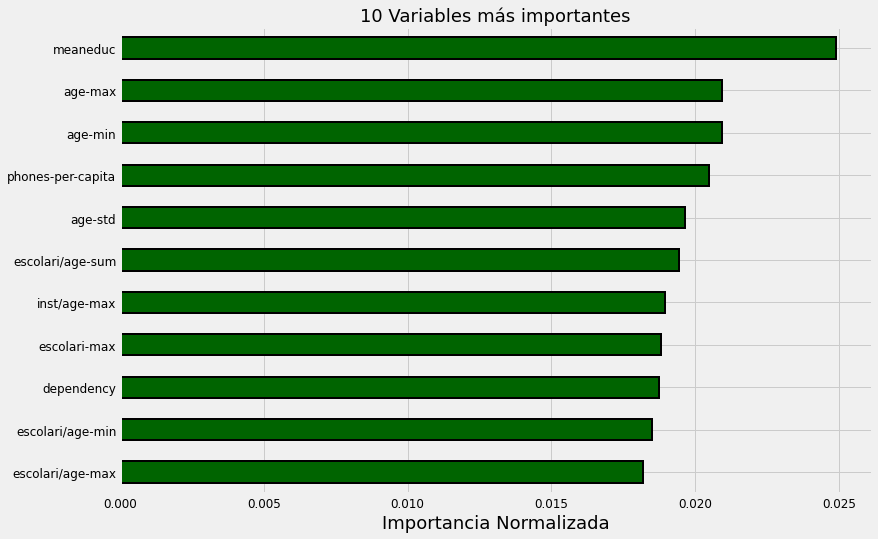

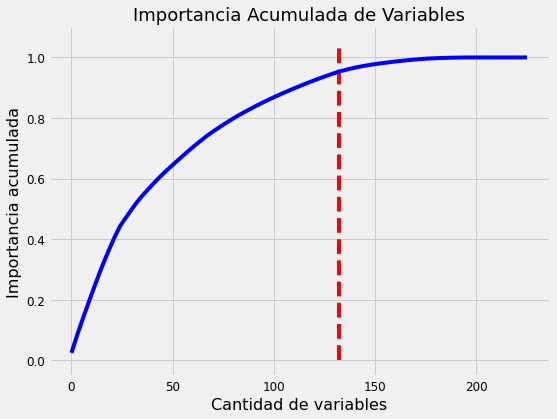

132 variables dan cuenta del 95% de importancia acumulada.


In [203]:
norm_fi = plot_feature_importances(feature_importances, threshold=0.95)

__La Educación Reina!__ La variable más importante es la educación promedio del hogar, seguido por el nivel de educación máximo obtenido por alguien en el hogar. Sospecho que estas variables pueden estar muy correlacionadas entre sí (colinearidad), por lo que tal vez deberíamos borarr alguna. Las siguientes variables de mayor importancia son una combinación de variables creadas y otras ya existenteas. 

Es interesante que solo necesitamos 106 de las ~180 variables para dar cuenta del 90% de la importancia acumulada de las variables. Esto nos dice que tal vez hay varias variables más que podríamos eliminar. 

In [205]:
def kde_target(df, variable):
    """Plots the distribution of `variable` in `df` colored by the `Target` column"""
    
    colors = {1: 'red', 2: 'orange', 3: 'blue', 4: 'green'}

    plt.figure(figsize = (12, 8))
    
    df = df[df['Target'].notnull()]
    
    for level in df['Target'].unique():
        subset = df[df['Target'] == level].copy()
        sns.kdeplot(subset[variable].dropna(), 
                    label = f'Poverty Level: {level}', 
                    color = colors[int(subset['Target'].unique())])

    plt.xlabel(variable); plt.ylabel('Densidad');
    plt.title('{} Distribución'.format(variable.capitalize()));

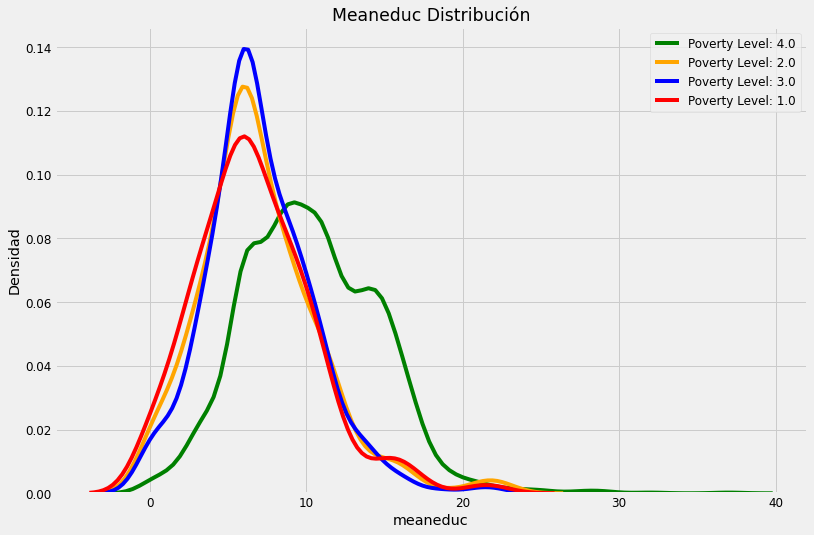

In [207]:
kde_target(final, 'meaneduc')

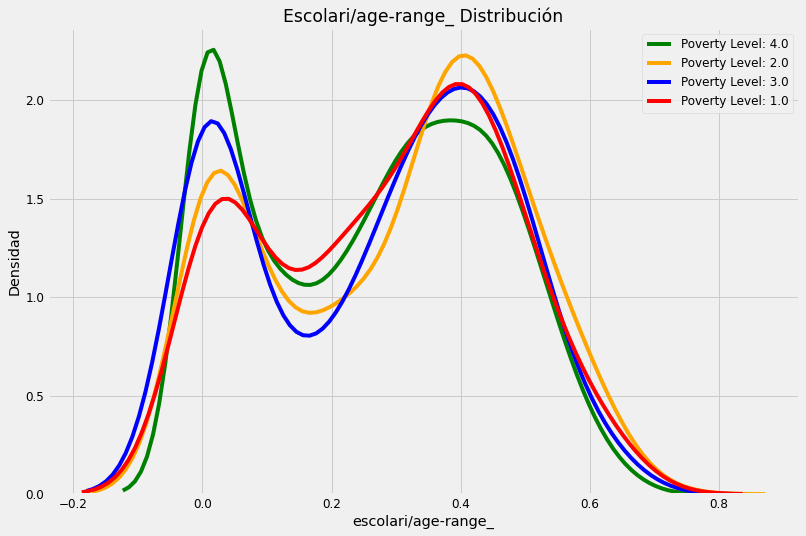

In [208]:
kde_target(final, 'escolari/age-range_')

# Selección del Modelo

Ya probamos el Random Forest Classifier que nos dio un máximo de macro F1 de 0.35. Sin embargo, en machine learning nunca sabemos qué modelo funcionará mejor para cada dataset. El siguiente gráfico muestra que hay ocasiones en que incluso el modelo Gaussian Naive Bayes tiene un mejor desempeño que el Gradient Boosing Machine. Para ir al artículo donde se encuentra el gráfico [pinche aquí](https://psb.stanford.edu/psb-online/proceedings/psb18/olson.pdf)

![algorithm_comparison](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/algorithm_comparison.png)

Entonces sabemos que debemos probar varios modelos para saber cuál tiene mejor desempeño en nuestros datos. Escribiremos una función que evalúa cada modelo. Armaremos un dataframe que tendrá los resultados y la función agregará una fila por cada modelo que probemos.

In [209]:
# Importamos los modelos
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [210]:
import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filtramos los warnings de los modelos
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

# armamos un dataframe que guarde los resultados
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

def cv_model(train, train_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    
    cv_scores = cross_val_score(model, train, train_labels, cv = 10, scoring=scorer, n_jobs = -1)
    print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_mean': cv_scores.mean(), 
                                                            'cv_std': cv_scores.std()},
                                                           index = [0]),
                                             ignore_index = True)

        return model_results

In [211]:
model_results = cv_model(train_set, train_labels, LinearSVC(), 
                         'LSVC', model_results)

10 Fold CV Score: 0.28552 with std: 0.03985


Tachamos este modelo la lista (aunque se podría mejorar su desempeño a modificando los hiperparámetros)

In [212]:
model_results = cv_model(train_set, train_labels, 
                         GaussianNB(), 'GNB', model_results)

10 Fold CV Score: 0.18451 with std: 0.03657


El desempeño de este modelo es muy bajo.

In [213]:
model_results = cv_model(train_set, train_labels, 
                         MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64, 32)),
                         'MLP', model_results)

10 Fold CV Score: 0.30387 with std: 0.04219


El "Multi-layer perceptron"(deep neural network) muetra un desempeño decente. 

In [214]:
model_results = cv_model(train_set, train_labels, 
                          LinearDiscriminantAnalysis(), 
                          'LDA', model_results)

10 Fold CV Score: 0.31792 with std: 0.06199


__Si corres `LinearDiscriminantAnalysis` sin filtrar los `UserWarning`, obtienes varios mensajes diciendo "Variables are collinear."__ Esto nos puede dar una pista para remover variables que presentan alta colinearidad.

In [215]:
model_results = cv_model(train_set, train_labels, 
                         RidgeClassifierCV(), 'RIDGE', model_results)

10 Fold CV Score: 0.27803 with std: 0.0342


El modelo lineal con regularización ridge tiene un muy buen desempeño. Parece que no necesitamos un modelo tan complejo.

In [216]:
for n in [5, 10, 20]:
    print(f'\nKNN with {n} neighbors\n')
    model_results = cv_model(train_set, train_labels, 
                             KNeighborsClassifier(n_neighbors = n),
                             f'knn-{n}', model_results)


KNN with 5 neighbors

10 Fold CV Score: 0.34765 with std: 0.03354

KNN with 10 neighbors

10 Fold CV Score: 0.31992 with std: 0.03213

KNN with 20 neighbors

10 Fold CV Score: 0.30723 with std: 0.04762


Intentaremos el ExtraTreesClassifier, una variante de random forest que usa árboles de decisiones también.

In [217]:
from sklearn.ensemble import ExtraTreesClassifier

model_results = cv_model(train_set, train_labels, 
                         ExtraTreesClassifier(n_estimators = 100, random_state = 10),
                         'EXT', model_results)

10 Fold CV Score: 0.32681 with std: 0.05096


## Comparando desempelo

Con los modelos en un dataframe podemos visualizarlos y compararlos

In [218]:
model_results = cv_model(train_set, train_labels,
                          RandomForestClassifier(100, random_state=10),
                              'RF', model_results)

10 Fold CV Score: 0.34394 with std: 0.04381


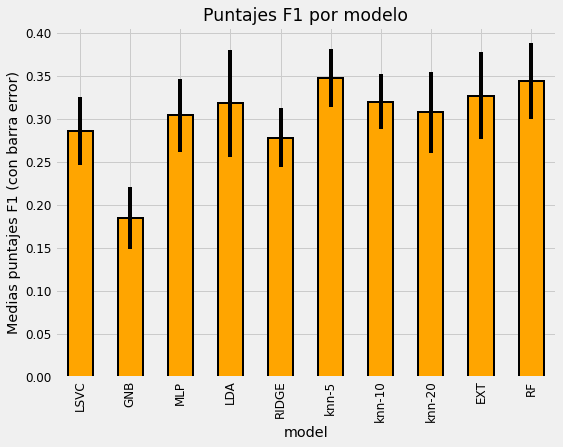

In [219]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']),
                                  edgecolor = 'k', linewidth = 2)
plt.title('Puntajes F1 por modelo');
plt.ylabel('Medias puntajes F1 (con barra error)');
model_results.reset_index(inplace = True)

El mejor candidato parece ser Random Forest.

# Comparemos con los datos de testeo
 
Por suerte ya formateamos nuestro dataset de testeo de forma que esté en el mismo formato que el dataset de entrenamiento.

Aunque estemos prediciendo a nivel de hogar, necesitamos una fila por individuo, pero la predicción solo se hará para los que encabecen cada hogar.

```
Id,Target
ID_2f6873615,1
ID_1c78846d2,2
ID_e5442cf6a,3
ID_a8db26a79,4
ID_a62966799,4 
```


El dataset `submission_base` tendrá todos los individuos del dataset de testeo, mientras que el dataset `test_ids` solo tendrá el `idhogar` de las personas que encabezan cada hogar. Al hacer la predicción, solo haremos la predicción por hogar y luego uniremos el dataset `predictions` al resto de los individuos por cada hogar (`idhogar`). Así la variable `Target` será la misma para cada persona que pertenece al mismo hogar. Para los hogares sin individuos que los encabecen, fijaremos sus predicciones a 4 ya que no serán puntuados.

In [220]:
test_ids = list(final.loc[final['Target'].isnull(), 'idhogar'])

La siguiente función toma un modelo, un set de entrenamiento, las etiquetas de entramiento y un set de testeo y hace lo siguiente:

* Entrena el modelo en los datos de entrenamiento usando `fit`
* Hace predicciones sobre los datos de testeo usando `predict`
* Crea un dataframe `submission` que puede ser guardado

In [221]:
def submit(model, train, train_labels, test, test_ids):
    """Train and test a model on the dataset"""
    
    # Entrenamos sobre los datos
    model.fit(train, train_labels)
    predictions = model.predict(test)
    predictions = pd.DataFrame({'idhogar': test_ids,
                               'Target': predictions})

     # Guardamos en dataframe
    submission = submission_base.merge(predictions, 
                                       on = 'idhogar',
                                       how = 'left').drop(columns = ['idhogar'])
    
    # Rellenamos hogares sin nadie que los encabece
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)

    return submission 

Probemos con Random Forest.

In [222]:
rf_submission = submit(RandomForestClassifier(n_estimators = 100, 
                                              random_state=10, n_jobs = -1), 
                         train_set, train_labels, test_set, test_ids)

rf_submission.to_csv('rf_submission.csv', index = False)

Estas predicciones puntúan __0.370__

# Selección de características

Intentaremos quedarnos solo con las variables más importantes para el modelo. Sacaremos todas las columnas que tengan una correlación de más de 0.95 entre sí (este es un criterio arbitrario, se podría elegir otro) y luego aplicaremos un proceso de eliminación de variables recursivo con la librería Scikit-Learn.

In [223]:
train_set = pd.DataFrame(train_set, columns = features)

# Creamos matriz de correlaciones
corr_matrix = train_set.corr()

# Seleccionamos triángulo superior
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Encontramos índice de columnas con corr mayor a 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['coopele', 'elec', 'v18q-count', 'female-sum']

In [224]:
train_set = train_set.drop(columns = to_drop)
train_set.shape

(2973, 222)

In [225]:
test_set = pd.DataFrame(test_set, columns = features)
train_set, test_set = train_set.align(test_set, axis = 1, join = 'inner')
features = list(train_set.columns)

### Eliminación recursiva de variables con Random Forest

 `RFECV` en Sklearn significa "Recursive Feature Elimination with Cross Validation". Usa un modelo que selecciona variables de acuerdo a su importancia de forma iterativa hasta que el proceso de validación cruzada ya no muestra mejoras.

Para crear el objeto "seleccionador" o `selector`, le debemos indicar el modelo, el número de características a eliminar en cada iteración, la cantidad de validaciones cruzadas, el seleccionador diseñado y cualquier otro parámetro que guíe la selección.

In [226]:
from sklearn.feature_selection import RFECV

# Creamos modelo de selección de variables
estimator = RandomForestClassifier(random_state = 10, n_estimators = 100,  n_jobs = -1)

# Creamos objeto
selector = RFECV(estimator, step = 1, cv = 3, scoring= scorer, n_jobs = -1)

Luego ajustamos con `fit` el seleccionador a los datos de entrenamiento, como cualquier otro modelo sklearn. Esto hara que continúe la selección de las variables hasta que los puntajes de la validación cruzada dejen de mejorar.

In [227]:
selector.fit(train_set, train_labels)

RFECV(cv=3,
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=-1,
                                       oob_score=False, random_state=10,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=-1,
      scoring=make_scorer(f1_score, average=macro), step=1, verbose=0)

Podemos revisar el objeto para ver los puntajes de entrenamiento para cada iteración. El código de a continuación plotea los puntajes de validación vs el número de craacterísticas en el dataset de entrenamiento.

169

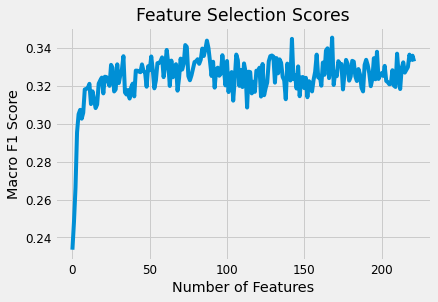

In [133]:
plt.plot(selector.grid_scores_);

plt.xlabel('Cantidad de variables'); plt.ylabel('Puntaje Macro F1'); plt.title('Puntaje de selección de variables');
selector.n_features_

El puntaje mejora a medida que agregamos variables, hasta que llegamos a 96 variables. De acuerdo a nuestro "seleccionador", esta es la cantidad óptima de variables para ingresar al modelo.

Los rankings de cada variables se pueden obtener inspeccionando el objeto entrenado. Representa, esencialmente, que la importancia 
The rankings of each feature can be found by inspecting the trained object. Nos quedamos solo con las variables con posición = 1.

In [134]:
rankings = pd.DataFrame({'variable': list(train_set.columns), 'posición': list(selector.ranking_)}).sort_values('posición')
rankings.head(10)

,feature,rank
110,female-range_,1
124,estadocivil5-sum,1
125,estadocivil6-min,1
126,estadocivil6-max,1
127,estadocivil7-min,1
128,estadocivil7-max,1
129,estadocivil7-sum,1
130,estadocivil7-std,1
133,parentesco1-std,1
135,parentesco2-max,1


Seleccionamos las variables y hacemos una validación cruzada nuevamente.

In [135]:
train_selected = selector.transform(train_set)
test_selected = selector.transform(test_set)

In [136]:
# Convertimos de vuelta a dataframe
selected_features = train_set.columns[np.where(selector.ranking_==1)]
train_selected = pd.DataFrame(train_selected, columns = selected_features)
test_selected = pd.DataFrame(test_selected, columns = selected_features)

In [137]:
model_results = cv_model(train_selected, train_labels, model, 'RF-SEL', model_results)

10 Fold CV Score: 0.35016 with std: 0.04098


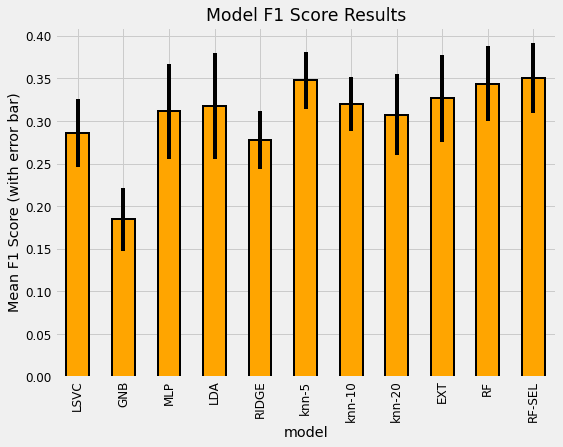

In [138]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']),
                                 edgecolor = 'k', linewidth = 2)
plt.title('Puntajes F1 por modelo');
plt.ylabel('Medias puntajes F1 (con barra error)');
model_results.reset_index(inplace = True)

El modelo con las variables seleccionadas tiene un desempeño levemente mejor en la validación cruzada.